In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('/home/dtward/data/csh_data/emlddmm')
sys.path.append('/home/abenneck/Desktop/emlddmm')
import emlddmm

from scipy.ndimage import distance_transform_edt
import time
import os
import csv

user = 'abenneck'
# user = 'dtward'

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# L0 CP regions
regionID_cp = 672 # Caudate Putamen

# L1 CP regions
regionID_cpr = 2491     # CP, rostral
regionID_cpre = 2376    # CP, rostral extreme
regionID_cpi = 2492     # CP, intermediate
regionID_cpc = 2496     # CP, caudal
regionID_cpce = 2495    # CP, caudal extreme

# L2 CP regions
regionID_cpr_m = 2294   # CPr, medial
regionID_cpr_imd = 2295 # CPr, intermediate dorsal
regionID_cpr_imv = 2296 # CPr, intermediate ventral
regionID_cpr_l = 2497   # CPr, lateral
regionID_cpi_dm = 2498  # CPi, dorsomedial
regionID_cpi_vm = 2500  # CPi, ventromedial
regionID_cpi_dl = 2499  # CPi, dorsolateral
regionID_cpi_vl = 2501  # CPi, ventrolateral
regionID_cpc_d = 2493   # CPc, dorsal
regionID_cpc_i = 2494   # CPc, intermediate
regionID_cpc_v = 2490   # CPc, ventral

# Non-CP gray matter regions
regionID_ast = 2050     # Amygdalostriatal nucleus
regionID_acb = 56       # Accumbens nucleus
regionID_ipac = 998     # Interstitial nucleus of the posterior limb of the anterior commissure
regionID_tu = 754       # Olfactory tubercle
regionID_lsx = 275      # Lateral septal complex
regionID_samy = 278     # Striatum-like amygdalar nuclei
regionID_pal = 803      # Pallidum
regionID_cl = 583       # Claustrum
regionID_en = 942       # Endopiriform nucleus
regionID_pir = 961      # Piriform nucleus

# Non-CP regions
regionID_lv = 81        # Lateral ventricle
regionID_3V = 129       # 3rd ventricle
regionID_Aq = 140       # Aqueduct
regionID_4V = 145       # 4th ventricle
regionID_centCan = 164  # Central canal
regionID_cc = 776       # Corpus callosum

## Step 0: Load data and plot 2 of the (x,y,z) coordinates with 1 property as a heatmap

In [3]:
def data_filter(data, type='', cluster=''):
    if type == '' and cluster == '':
        return data

    if type != '' and cluster == '':
        return data[data['Type'] == type]

    return data[data['Cluster'] == f'{type} - {cluster}']

# Round neuron coord to nearest atlas coord
def roundCoord(sub_xS, coord):
    if coord < np.min(sub_xS):
        coord = np.min(sub_xS)
    elif coord > np.max(sub_xS):
        coord = np.max(sub_xS)
    else:
        coord_rounded = 20*round(coord/20) # Round coordinate to nearest 20
        if coord < 0:
            if coord - coord_rounded >= 0:
                coord = coord_rounded + 10
            else:
                coord = coord_rounded - 10
        else:
            if coord - coord_rounded >= 0:
                coord = coord_rounded + 10
            else:
                coord = coord_rounded - 10
    return coord

In [4]:
# Load data
pos_and_metric_path = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/morpho_and_dist_inner.csv'
data = pd.read_csv(pos_and_metric_path)

neuron_type = ''
# neuron_type = 'D1'
# neuron_type = 'D2'

neuron_cluster = ''
# cluster = 'A'
# cluster = 'B'

data = data_filter(data, neuron_type, neuron_cluster)

In [5]:
xcoords = data['x']
ycoords = data['y']
zcoords = data['z']

prop_name = 'N branch'
prop = data[prop_name]

# (11/30/23) Flip cells, so that L/R hemispheres can be averaged together
xcoords = np.concatenate((xcoords,xcoords))
ycoords = np.concatenate((ycoords,-ycoords))
zcoords = np.concatenate((zcoords,zcoords))
prop = np.concatenate((prop,prop))

data.columns

Index(['fname', 'key_name', 'x', 'y', 'z', 'slice', 'hemi', 'D(CP)', 'D(LV)',
       'D(3V)', 'D(Aq)', 'D(4V)', 'D(centCan)', 'D(cc)', 'D(brainBound)',
       'file path', 'Brain', 'Type', 'Sex', 'Striatal.Subregion', 'Cluster',
       'Bif ampl local', 'Bif ampl remote', 'Branch Order', 'Contraction',
       'Depth', 'Diameter', 'Sum EucDistance', 'Max EucDistance',
       'Fractal Dim', 'Fragmentation', 'Height', 'Length', 'N bifs',
       'N branch', 'N stems', 'N tips', 'Partition asymmetry',
       'Sum PathDistance', 'Max PathDistance', 'Pk classic', 'Surface',
       'Volume', 'Width', 'Terminal degree', 'Bif tilt local',
       'Bif tilt remote', 'Bif torque local', 'Bif torque remote', 'Helix',
       'ABEL All', 'ABEL Terminal', 'ABEL Internal', 'BAPL Internal',
       'abel terminal', 'BAPL Terminal'],
      dtype='object')

Text(0.5, 1.0, 'Coronal view of N branch')

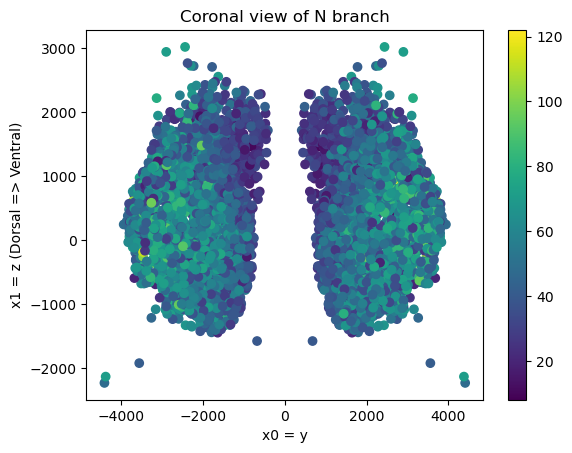

In [6]:
fig, ax = plt.subplots()

# ax.grid(True)
h = ax.scatter(ycoords, zcoords, c = prop)
plt.colorbar(h)

ax.set_xlabel('x0 = y')
ax.set_ylabel('x1 = z (Dorsal => Ventral)')
ax.set_title(f'Coronal view of {prop_name}')

Text(0.5, 1.0, 'Axial view of N branch')

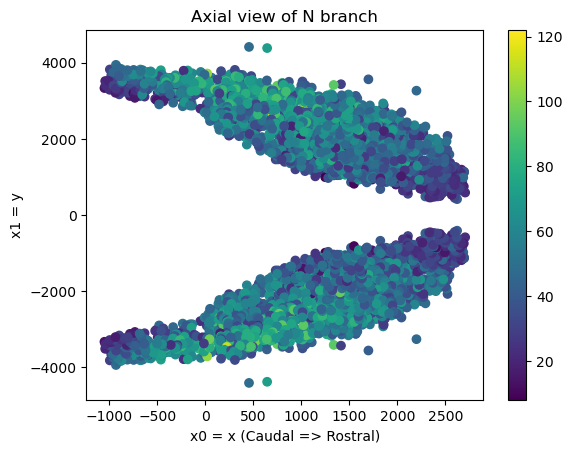

In [7]:
fig, ax = plt.subplots()

# ax.grid(True)
h = ax.scatter(xcoords, ycoords, c = prop)
plt.colorbar(h)

ax.set_xlabel('x0 = x (Caudal => Rostral)')
ax.set_ylabel('x1 = y')
ax.set_title(f'Axial view of {prop_name}')

Text(0.5, 1.0, 'Sagittal view of N branch')

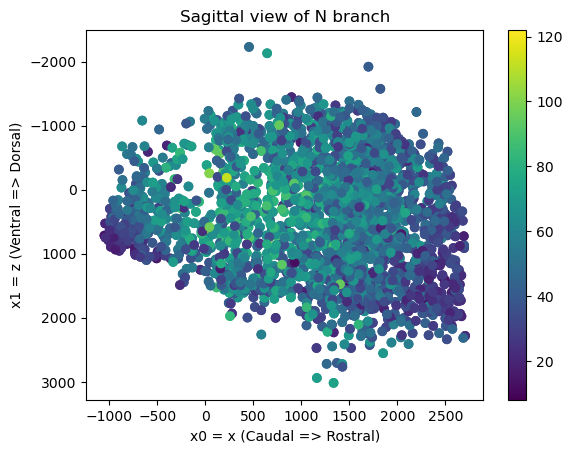

In [8]:
fig, ax = plt.subplots()

# ax.grid(True)
h = ax.scatter(xcoords, zcoords, c = prop)
plt.colorbar(h)

ax.invert_yaxis()
ax.set_xlabel('x0 = x (Caudal => Rostral)')
ax.set_ylabel('x1 = z (Ventral => Dorsal)')
ax.set_title(f'Sagittal view of {prop_name}')

## Load the Atlas

In [9]:
ontology_name = f'/home/{user}/mounts/bmaproot/nafs/dtward/dong/upenn_atlas/atlas_info_KimRef_FPbasedLabel_v2.7.csv'
seg_name = f'/home/{user}/mounts/bmaproot/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'

# Load Atlas coordinates
xS,S,_,_ = emlddmm.read_data(seg_name)

atlas_x, atlas_y, atlas_z = xS

In [10]:
# Load dict relating parent regions w child regions
ontology_name = '/home/abenneck/nafs/dtward/dong/upenn_atlas/atlas_info_KimRef_FPbasedLabel_v2.7.csv'

parent_column = 7 # 8 for allen, 7 for yongsoo
label_column = 0 # 0 for both
shortname_column = 2# 3 for allen, 2 for yongsoo
longname_column = 1# 2 for allen, 1 for yongsoo
ontology = dict()
with open(ontology_name) as f:
    csvreader = csv.reader(f, delimiter=',', quotechar='"')
    count = 0
    for row in csvreader:        
        if count == 0:
            headers = row
            print(headers)
        else:
            if not row[parent_column]:
                parent = -1
            else:
                parent = int(row[parent_column])
            ontology[int(row[label_column])] = (row[shortname_column],row[longname_column],parent)
        count += 1

children = dict()
for o in ontology:
    parent = ontology[o][-1]
    if parent not in children:
        children[parent] = []
    children[parent].append(o)

# now we go from children to descendents
descendents = dict(children)
for o in descendents:
    for child in descendents[o]:
        if child in descendents: # if I don't do this i get a key error 0
            descendents[o].extend(descendents[child])
descendents[0] = []

descendents_and_self = dict(descendents)
for o in ontology:
    if o not in descendents_and_self:
        descendents_and_self[o] = [o]
    else:
        descendents_and_self[o].append(o)

['\ufeffid', 'name', 'acronym', 'red', 'green', 'blue', 'structure_order', 'parent_id', 'parent_acronym']


In [11]:
# Returns a mask where regional boundary voxels are 1 and all other voxels are 0
def generate_regional_boundary_mask(S, regionsIDs, fname, shift = 0):
    if shift == 0:
        S_bound = np.zeros_like(S)
    else: # Load the presaved mask:
        S_bound = np.load(f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/{fname}')
        S_bound = S_bound['mask']
    
    for voxelID in regionsIDs[shift:]:
        start = time.time()
        print(f'({np.where(regionIDs == voxelID)[0][0]}/{len(regionsIDs)-1}) Starting region {voxelID}')
        
        S_temp = np.zeros_like(S)
        
        self_and_children = list(descendents_and_self[voxelID])
        for nodeID in self_and_children:
            S_temp[S == nodeID] = 1 # Sets all voxels labelled as 'voxelID' to 1, and all other voxels remain 0
            
        boundary_mask = distance_transform_edt(S_temp)  # Computes distance transform of subregion
        boundary_mask[boundary_mask != 1.0] = 0.0  # Only boundary pixels have a value of 1.0 (pixels inside > 1.0 and pixels outside = 0.0)
        
        S_bound = np.logical_or(S_bound,boundary_mask == 1.0)        
        np.savez(f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/{fname}', mask = S_bound)
        
        print(f'Finished region {voxelID} in {time.time() - start}s\n')

genRBM = False

# # Creating S_bound for ALL regions
# shift = 815
# regionIDs = np.unique(S)[1:]
# fname = 'S_bound.npz'

# # Creating S_bound for only CP + non-CP regions used in probabilistic assignments
# shift = 31
# regionIDs = np.asarray([regionID_cp, regionID_cpr, regionID_cpre, regionID_cpi, regionID_cpc, regionID_cpce, regionID_cpr_m, regionID_cpr_imd, regionID_cpr_imv, regionID_cpr_l, 
#              regionID_cpi_dm, regionID_cpi_vm, regionID_cpi_dl, regionID_cpi_vl, regionID_cpc_d, regionID_cpc_i, regionID_cpc_v, regionID_ast, regionID_acb, regionID_ipac,
#              regionID_tu, regionID_lsx, regionID_samy, regionID_pal, regionID_cl, regionID_en, regionID_pir, regionID_lv, regionID_3V, regionID_Aq, regionID_4V,
#              regionID_centCan, regionID_cc])
# fname = 'S_bound_prob_new.npz'

# Creating S_bound for CP, ventricles, and ACB
shift = 4
regionIDs = np.asarray([regionID_cp, regionID_cpr, regionID_cpre, regionID_cpi, regionID_cpc, regionID_cpce, regionID_cpr_m, regionID_cpr_imd, regionID_cpr_imv, regionID_cpr_l, 
                        regionID_cpi_dm, regionID_cpi_vm, regionID_cpi_dl, regionID_cpi_vl, regionID_cpc_d, regionID_cpc_i, regionID_cpc_v, regionID_acb, 
                        regionID_lv, regionID_3V, regionID_Aq, regionID_4V, regionID_centCan, regionID_cc])
fname = 'S_bound_prob_cp_vent.npz'

if genRBM:
    generate_regional_boundary_mask(S, regionIDs, fname, shift)

In [12]:
# # Returns a mask where boundary voxels are 1 and all other voxels are 0
# def generate_brain_boundary_mask(S):
#     boundary_mask = distance_transform_edt(S)  # Computes distance transform of entire brain
#     boundary_mask[boundary_mask != 1.0] = 0.0  # Only boundary pixels have a value of 1.0 (pixels inside > 1.0 and pixels outside = 0.0)
#     return boundary_mask

# S_brain_bound = generate_brain_boundary_mask(S)

# fname = 'S_bound_prob_cp_vent.npz'
# S_bound = np.load(f'/home/abenneck/nafs/dtward/andrew_work/test/dragonfly_work/{fname}')
# S_bound = S_bound['mask']

# # Appends brain boundary mask to S_bound
# S_bound = np.logical_or(S_bound, S_brain_bound == 1)

# np.savez(f'/home/abenneck/nafs/dtward/andrew_work/test/dragonfly_work/{fname}', mask = S_bound)

In [13]:
# Display all (coronal/sagittal/axial) slices of S_bound
fname = 'S_bound_prob_cp_vent.npz'
S_bound = np.load(f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/{fname}')
S_bound = S_bound['mask']

# # nrow, ncol = 74, 5
# nrow, ncol = 120, 5
# # nrow, ncol = 100, 5
# idx = 0
# fig, ax = plt.subplots(nrow, ncol)
# for i in np.arange(nrow):
#     for j in np.arange(ncol):
#         # ax[i,j].imshow(S_bound[0,:,:,idx], cmap = 'binary')
#         ax[i,j].imshow(S_bound[0,idx,:,:], cmap = 'binary')
#         ax[i,j].set_title(f'({idx},{atlas_x[idx]})')
#         idx += 1

# fig.set_size_inches(ncol*3, nrow*3)
# fig.subplots_adjust(hspace = 0.3)

# Example in 2D

## Step 1: Define a voxel grid

In [14]:
xmin = np.min(xcoords)
xmax = np.max(xcoords)

ymin = np.min(ycoords)
ymax = np.max(ycoords)

zmin = np.min(zcoords)
zmax = np.max(zcoords)

print(f'xrange: ({xmin}, {xmax}), yrange: ({ymin},{ymax}), zrange: ({zmin},{zmax})')

xrange: (-1051.66552734375, 2704.8984375), yrange: (-4413.7392578125,4413.7392578125), zrange: (-2229.366943359375,3017.5400390625)


In [15]:
# Rounding min and max to nearest 100 away from 0
# x0 = np.arange(-4000,4500,50)
# x1 = np.arange(-2300,3100,50)
# X = np.stack(np.meshgrid(x0,x1,indexing='ij'),-1)

# ===== Use a subset of the atlas coordinates =====
# Coronal
x0 = np.arange(roundCoord(atlas_z,np.min(zcoords)),roundCoord(atlas_z,np.max(zcoords)),20)
x1 = np.arange(roundCoord(atlas_y,np.min(ycoords)),roundCoord(atlas_y,np.max(ycoords)),20)
x = list(zip(zcoords, ycoords))

# # Sagittal
# x0 = np.arange(roundCoord(atlas_z,np.min(zcoords)),roundCoord(atlas_z,np.max(zcoords)),20)
# x1 = np.arange(roundCoord(atlas_x,np.min(xcoords)),roundCoord(atlas_x,np.max(xcoords)),20)
# x = list(zip(zcoords, xcoords))

# # Axial
# x0 = np.arange(roundCoord(atlas_y,np.min(ycoords)),roundCoord(atlas_y,np.max(ycoords)),20)
# x1 = np.arange(roundCoord(atlas_x,np.min(xcoords)),roundCoord(atlas_x,np.max(xcoords)),20)
# x = list(zip(ycoords, xcoords))

X = np.stack(np.meshgrid(x0,x1,indexing='ij'),-1)

## Step 2: Estimate local cell density

Finished in 14.22s


Text(0.5, 1.0, 'Local density of cells')

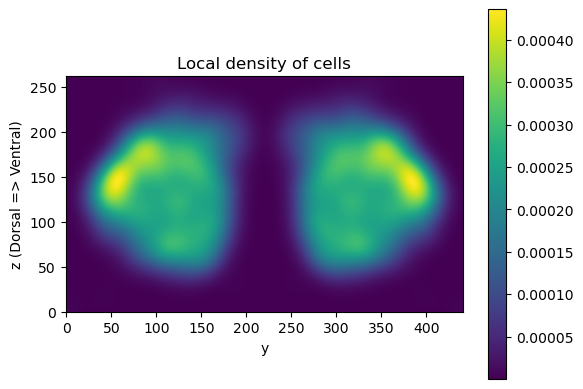

In [16]:
start = time.time()

density = np.zeros_like(X[...,0], dtype = 'float64')
sigma = 250
for coord in x:
    density += np.exp(  np.sum(-(X - coord)**2/2/sigma**2, -1 ) )/np.sqrt(2.0*np.pi*sigma**2)**2

print(f'Finished in {time.time() - start:.2f}s')
fig,ax = plt.subplots()

# Plots 
h = ax.imshow(density)
plt.colorbar(h)

# note that the y axis is flipped by default, relative to what we sa
ax.invert_yaxis()

ax.set_xlabel('y')
ax.set_ylabel('z (Dorsal => Ventral)')
ax.set_title(f'Local density of cells')

Finished in 1.00s


Text(0.5, 1.0, 'Local density of cells')

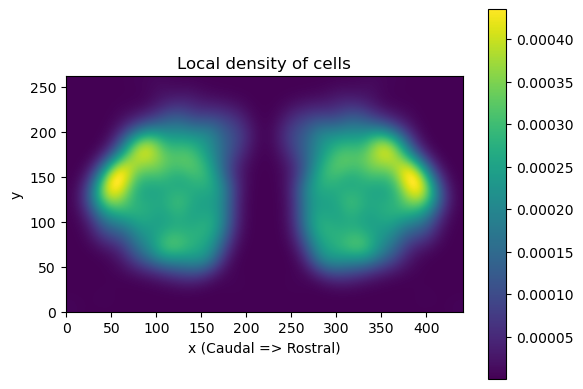

In [17]:
start = time.time()

density = np.zeros_like(X[...,0], dtype = 'float64')
sigma = 250
voxel_radius = int( (sigma*3)/(x0[1] - x0[0]) ) # 3 standard deviations is a box of size 75
for coord in x:
    # what voxel coordsponds to this coordinate
    row = int( (coord[0] - x0[0])/(x0[1] - x0[0]) )
    rowmin = np.max( (row-voxel_radius,0) )
    rowmax = np.min( (row+voxel_radius,len(x0)-1) )
    col = int( (coord[1] - x1[0])/(x1[1] - x1[0]) )
    colmin = np.max( (col-voxel_radius,0) )
    colmax = np.min( (col+voxel_radius,len(x1)-1) )
    
    # apply slicing to only do this computation where the gaussian is significantly different from 0
    density[rowmin:rowmax+1,colmin:colmax+1] += np.exp(  np.sum(-(X[rowmin:rowmax+1,colmin:colmax+1] - coord)**2/2/sigma**2, -1 ) )/np.sqrt(2.0*np.pi*sigma**2)**2

density[density == 0.0] = np.unique(density)[1]

print(f'Finished in {time.time() - start:.2f}s')
fig,ax = plt.subplots()

# Plots 
h = ax.imshow(density)
plt.colorbar(h)

# note that the y axis is flipped by default, relative to what we sa
ax.invert_yaxis()

ax.set_xlabel('x (Caudal => Rostral)')
ax.set_ylabel('y')
ax.set_title(f'Local density of cells')

## Step 3: Estimate local property averages

Text(0.5, 1.0, 'Local average of N branch')

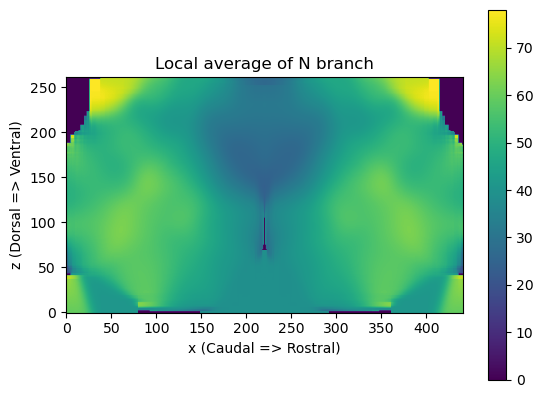

In [18]:
local_avg = np.zeros_like(X[...,0], dtype = 'float64')
for xi,pi in zip(x,prop):
    # what voxel coordsponds to this coordinate
    row = int( (xi[0] - x0[0])/(x0[1] - x0[0]) )
    rowmin = np.max( (row-voxel_radius,0) )
    rowmax = np.min( (row+voxel_radius,len(x0)-1) )
    
    col = int( (xi[1] - x1[0])/(x1[1] - x1[0]) )
    colmin = np.max( (col-voxel_radius,0) )
    colmax = np.min( (col+voxel_radius,len(x1)-1) )
    
    local_avg[rowmin:rowmax+1,colmin:colmax+1] += np.exp(  np.sum(-(X[rowmin:rowmax+1,colmin:colmax+1] - xi)**2/2/sigma**2, -1 ) )/np.sqrt(2.0*np.pi*sigma**2)**2 * pi

# local_avg is actually a local sum until we divide by density
local_avg = local_avg / density

fig,ax = plt.subplots()
# ax.scatter(zcoords, ycoords)
h = ax.imshow(local_avg, vmin=np.min(local_avg), vmax=np.max(local_avg))

plt.colorbar(h)

ax.invert_yaxis()
ax.set_xlabel('x (Caudal => Rostral)')
ax.set_ylabel('z (Dorsal => Ventral)')
ax.set_title(f'Local average of {prop_name}')

## Step 4: Render local_avg map with transparency

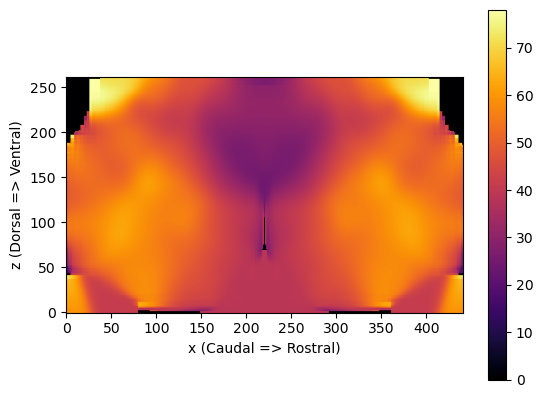

In [19]:
vmin = np.min(local_avg)
vmax = np.max(local_avg)

cm = plt.cm.inferno
local_avg_norm = (local_avg - vmin) / (vmax-vmin)
# RGBA = cm(local_avg/np.max(local_avg))
RGBA = cm(local_avg_norm)

fig,ax = plt.subplots()
h = ax.imshow(RGBA, vmin=vmin, vmax=vmax, cmap=cm)
ax.invert_yaxis()
ax.set_xlabel('x (Caudal => Rostral)')
ax.set_ylabel('z (Dorsal => Ventral)')
plt.colorbar(h)

### Step 4.1: Set map to 0 when far away from cells

Text(0, 0.5, 'z (Dorsal => Ventral)')

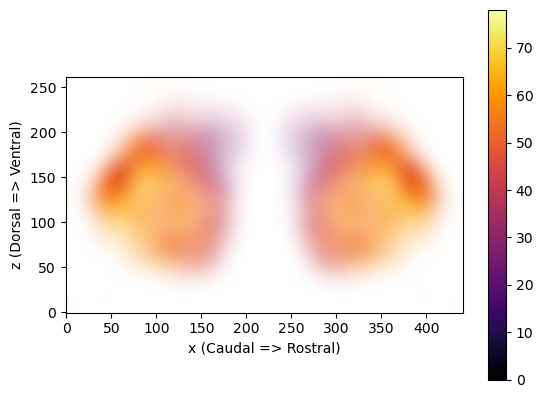

In [20]:
RGBA[...,-1] = density/np.max(density)

# RGBA = np.rot90(RGBA, k=1)
fig,ax = plt.subplots()
h = ax.imshow(RGBA,cmap=cm,vmin=vmin,vmax=vmax) # extra arguments are for making a colorbar

# we need a colorbar
fig.colorbar(h)

ax.invert_yaxis()
ax.set_xlabel('x (Caudal => Rostral)')
ax.set_ylabel('z (Dorsal => Ventral)')

## Step 4.2: Put atlas behind heatmap

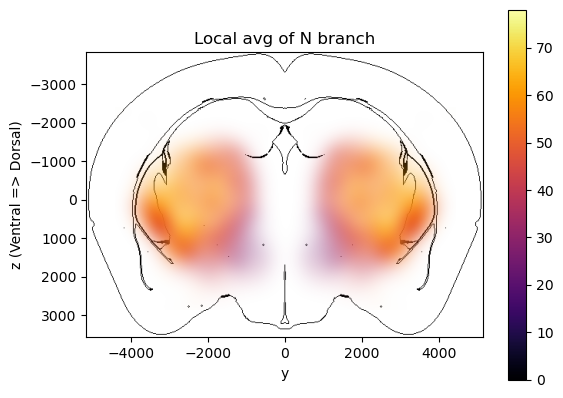

In [21]:
# 2D Coronal display
fig,ax = plt.subplots()

sub_S_bound = S_bound[0,299,:,:]
sub_S_bound = np.rot90(sub_S_bound,k=1)
sub_S_bound = np.flip(sub_S_bound,axis=0)
ax.imshow(sub_S_bound, cmap = 'binary', extent = (np.min(atlas_y), np.max(atlas_y), np.max(atlas_z), np.min(atlas_z)))

zshift = 150
# Plots 
sub_RGBA = RGBA
# sub_RGBA = np.rot90(sub_RGBA, k=2)
# sub_RGBA = np.flip(sub_RGBA, axis=0)
h = ax.imshow(sub_RGBA, cmap=cm,vmin=np.min(local_avg),vmax=np.max(local_avg), extent = (np.min(ycoords),np.max(ycoords),np.max(zcoords)-zshift,np.min(zcoords)-zshift)) # 'extent': Defines area which 'density' will fill
plt.colorbar(h)

# note that the y axis is flipped by default, relative to what we sa
# ax.invert_yaxis()

ax.set_xlabel('y')
ax.set_ylabel('z (Ventral => Dorsal)')
ax.set_title(f'Local avg of {prop_name}')

# Changes axes labels from idx of 'density' to (z,y) coords from atlas
ax.set_xticks(atlas_y, minor = True)
ax.set_yticks(atlas_z, minor = True)
ax.minorticks_off()

# fig.set_size_inches(10,7)

In [22]:
# # 2D Sagittal display
# RGBA = cm(local_avg/np.max(local_avg))
# RGBA[...,-1] = density/np.max(density)
# RGBA = np.rot90(RGBA, k=0)

# fig,ax = plt.subplots()

# sub_S_bound = S_bound[0,:,162,:]
# sub_S_bound = np.rot90(sub_S_bound,k=3)
# ax.imshow(sub_S_bound, cmap = 'binary', extent = (np.max(atlas_x), np.min(atlas_x), np.max(atlas_z), np.min(atlas_z)))

# # Plots 
# h = ax.imshow(RGBA, cmap=cm, vmin=np.min(local_avg),vmax=np.max(local_avg), extent = (np.min(xcoords),np.max(xcoords),np.max(zcoords),np.min(zcoords))) # 'extent': Defines area which 'density' will fill
# plt.colorbar(h)

# # note that the y axis is flipped by default, relative to what we sa
# # ax.invert_xaxis()

# ax.set_xlabel('x (Caudal => Rostral)')
# ax.set_ylabel('z (Dorsal => Ventral)')
# ax.set_title(f'Local avg of {prop_name}')

# # Changes axes labels from idx of 'density' to (z,y) coords from atlas
# ax.set_xticks(atlas_x, minor = True)
# ax.set_yticks(atlas_z, minor = True)
# ax.minorticks_off()

# # fig.set_size_inches(10,7)

In [23]:
# # 2D Axial display
# fig,ax = plt.subplots()

# sub_S_bound = S_bound[0,:,:,237]
# # sub_S_bound = np.rot90(sub_S_bound,k=2)
# ax.imshow(sub_S_bound, cmap = 'binary', extent = (np.max(atlas_y), np.min(atlas_y), np.max(atlas_x), np.min(atlas_x)))

# # Plots 
# # h = ax.imshow(RGBA, cmap=cm,vmin=np.min(local_avg),vmax=np.max(local_avg), extent = (np.min(x0),np.max(x0),np.min(x1),np.max(x1))) # 'extent': Defines area which 'density' will fill
# sub_RGBA = np.rot90(RGBA, k=3)
# h = ax.imshow(sub_RGBA, cmap=cm,vmin=np.min(local_avg),vmax=np.max(local_avg), extent = (np.max(ycoords),np.min(ycoords),np.max(xcoords),np.min(xcoords))) # 'extent': Defines area which 'density' will fill
# plt.colorbar(h)

# # note that the y axis is flipped by default, relative to what we sa
# # ax.invert_yaxis()

# ax.set_xlabel('y')
# ax.set_ylabel('x (Caudal => Rostral)')
# ax.set_title(f'Local avg of {prop_name}')

# # Changes axes labels from idx of 'density' to (z,y) coords from atlas
# ax.set_xticks(atlas_y, minor = True)
# ax.set_yticks(atlas_x, minor = True)
# ax.minorticks_off()

# # fig.set_size_inches(10,7)

# Example in 3D

## Step 1: Define voxel grid

In [24]:
def init_voxel_grid(data, xS):

    xcoords = data['x']
    ycoords = data['y']
    zcoords = data['z']

    atlas_x, atlas_y, atlas_z = xS
    
    x = zip(ycoords, zcoords, xcoords)
    
    # Use a subset of the atlas coordinates
    x0 = np.arange(roundCoord(atlas_y,np.min(ycoords)), roundCoord(atlas_y,np.max(ycoords)),20)
    x1 = np.arange(roundCoord(atlas_z,np.min(zcoords)), roundCoord(atlas_z,np.max(zcoords)),20)
    x2 = np.arange(roundCoord(atlas_x,np.min(xcoords)), roundCoord(atlas_x,np.max(xcoords)),20)
    
    X = np.stack(np.meshgrid(x0,x1,x2,indexing='ij'),-1)

    return x, X

# x, X = init_voxel_grid(data, xS)

# print(f'atlas_x: [{np.min(atlas_x)},{np.max(atlas_x)}]')
# print(f'atlas_y: [{np.min(atlas_y)},{np.max(atlas_y)}]')
# print(f'atlas_z: [{np.min(atlas_z)},{np.max(atlas_z)}]')

# print(f'x0: [{np.min(x0)},{np.max(x0)}]')
# print(f'x1: [{np.min(x1)},{np.max(x1)}]')
# print(f'x2: [{np.min(x2)},{np.max(x2)}]')

## Step 2: Estimate local cell density

In [25]:
def local_cell_density(neuron_type, neuron_cluster, data=None, xS=None, bounds = [-1500, 3000, -4500, 4500, -2500, 3500]):
    user = 'abenneck'
    if neuron_type != 'D1' and neuron_type != 'D2':
        density_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_densities/local_density.npz'
    else:
        cell_type = f'_{neuron_type}{neuron_cluster}'
        density_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_densities/local_density{cell_type}.npz'
    
    if os.path.exists(density_fpath):
        density = np.load(density_fpath)
        density = density['density']
        print(f'Loaded density from {density_fpath}')
    else:
        # if data == None or xS == None:
        #     raise Exception('Missing data or xS')
        
        data = data_filter(data, neuron_type, neuron_cluster)

        # Extract coordinate data from 'data'
        xcoords = data['x']
        xcoords = np.concatenate((xcoords,xcoords))
        ycoords = data['y']
        ycoords = np.concatenate((ycoords,-ycoords))
        zcoords = data['z']
        zcoords = np.concatenate((zcoords,zcoords))
        x = zip(ycoords, zcoords, xcoords)

        # Extract coordinate axes from atlas
        atlas_x, atlas_y, atlas_z = xS

        # Define bounds of subset of data
        xmin, xmax, ymin, ymax, zmin, zmax = bounds
    
        # Use a subset of the atlas coordinates
        # x0 = np.arange(roundCoord(atlas_y,np.min(ycoords)), roundCoord(atlas_y,np.max(ycoords)),20)
        # x1 = np.arange(roundCoord(atlas_z,np.min(zcoords)), roundCoord(atlas_z,np.max(zcoords)),20)
        # x2 = np.arange(roundCoord(atlas_x,np.min(xcoords)), roundCoord(atlas_x,np.max(xcoords)),20)
        x0 = np.arange(ymin, ymax, 20)
        x1 = np.arange(zmin, zmax, 20)
        x2 = np.arange(xmin, xmax, 20)
        X = np.stack(np.meshgrid(x0,x1,x2,indexing='ij'),-1)
        
        density = np.zeros_like(X[...,0], dtype = 'float64')
        sigma = 250
        voxel_radius = int( (sigma*3)/(x0[1] - x0[0]) ) # 3 standard deviations is a box of size 75
        count = 0
        start = time.time()
        for coord in x:
            # what voxel coordsponds to this coordinate
            row = int( (coord[0] - x0[0])/(x0[1] - x0[0]) )
            rowmin = np.max( (row-voxel_radius,0) )
            rowmax = np.min( (row+voxel_radius,len(x0)-1) )
            
            col = int( (coord[1] - x1[0])/(x1[1] - x1[0]) )
            colmin = np.max( (col-voxel_radius,0) )
            colmax = np.min( (col+voxel_radius,len(x1)-1) )
            
            dep = int( (coord[2] - x2[0])/(x2[1] - x2[0]) )
            depmin = np.max( (dep-voxel_radius,0) )
            depmax = np.min( (dep+voxel_radius,len(x2)-1) )

            # apply slicing to only do this computation where the gaussian is significantly different from 0
            density[rowmin:rowmax+1,colmin:colmax+1,depmin:depmax+1] += np.exp(  np.sum(-(X[rowmin:rowmax+1,colmin:colmax+1,depmin:depmax+1] - coord)**2/2/sigma**2, -1 ) )/np.sqrt(2.0*np.pi*sigma**2)**2
            
            # density += np.exp(  np.sum(-(X - coord)**2/2/sigma**2, -1 ) )/np.sqrt(2.0*np.pi*sigma**2)**3
            if count % 200 == 0:
                print(f'Finished {count}/{len(xcoords)} in {time.time() - start:.2f}s')
                start = time.time()
            count+=1
        np.savez(density_fpath, density = density)
    
    return density

## Step 3: Estimate local property average

In [26]:
def local_prop_average(neuron_type, neuron_cluster, prop_name, data=None, density=None, xS=None, bounds = [-1500, 3000, -4500, 4500, -2500, 3500]):
    user = 'abenneck'
    if neuron_type != 'D1' and neuron_type != 'D2':
        avg_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_averages/local_avg_{prop_name}.npz'
    else:
        cell_type = f'_{neuron_type}{neuron_cluster}'
        avg_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_averages/local_avg_{prop_name}{cell_type}.npz'
        
    if os.path.exists(avg_fpath):
        local_avg = np.load(avg_fpath)
        local_avg = local_avg['local_avg']
        print(f'Loaded local_avg from {avg_fpath}')
    else:
        # Gets rid of divide by 0 error with minimal manipulation of data
        density[density == 0.0] = np.unique(density)[1] # Set all instances of 0.0 to the second lowest value from 'density'

        data = data_filter(data, neuron_type, neuron_cluster)

        # Extract coordinate data from 'data'
        xcoords = data['x']
        xcoords = np.concatenate((xcoords,xcoords))
        ycoords = data['y']
        ycoords = np.concatenate((ycoords,-ycoords))
        zcoords = data['z']
        zcoords = np.concatenate((zcoords,zcoords))
        prop = data[prop_name]
        prop = np.concatenate((prop,prop))

        # Extract coordinate axes from atlas
        atlas_x, atlas_y, atlas_z = xS
    
        # Define bounds of subset of data
        xmin, xmax, ymin, ymax, zmin, zmax = bounds
    
        # Use a subset of the atlas coordinates
        # x0 = np.arange(roundCoord(atlas_y,np.min(ycoords)), roundCoord(atlas_y,np.max(ycoords)),20)
        # x1 = np.arange(roundCoord(atlas_z,np.min(zcoords)), roundCoord(atlas_z,np.max(zcoords)),20)
        # x2 = np.arange(roundCoord(atlas_x,np.min(xcoords)), roundCoord(atlas_x,np.max(xcoords)),20)
        x0 = np.arange(ymin, ymax, 20)
        x1 = np.arange(zmin, zmax, 20)
        x2 = np.arange(xmin, xmax, 20)
        X = np.stack(np.meshgrid(x0,x1,x2,indexing='ij'),-1)

        # Initialize local_avg structure + fill it in
        local_avg = np.zeros_like(X[...,0], dtype = 'float64')
        sigma = 250
        voxel_radius = int( (sigma*3)/(x0[1] - x0[0]) ) # 3 standard deviations is a box of size 75
        count = 0
        start = time.time()
        for yi,zi,xi,pi in zip(ycoords,zcoords,xcoords,prop):
            # what voxel coordsponds to this coordinate
            row = int( (yi - x0[0])/(x0[1] - x0[0]) )
            rowmin = np.max( (row-voxel_radius,0) )
            rowmax = np.min( (row+voxel_radius,len(x0)-1) )
            
            col = int( (zi - x1[0])/(x1[1] - x1[0]) )
            colmin = np.max( (col-voxel_radius,0) )
            colmax = np.min( (col+voxel_radius,len(x1)-1) )
            
            dep = int( (xi - x2[0])/(x2[1] - x2[0]) )
            depmin = np.max( (dep-voxel_radius,0) )
            depmax = np.min( (dep+voxel_radius,len(x2)-1) )

            local_avg[rowmin:rowmax+1,colmin:colmax+1,depmin:depmax+1] += np.exp(  np.sum(-(X[rowmin:rowmax+1,colmin:colmax+1,depmin:depmax+1] - [yi,zi,xi])**2/2/sigma**2, -1 ) )/np.sqrt(2.0*np.pi*sigma**2)**3 * pi
            if count % 200 == 0:
                print(f'Finished {count}/{len(xcoords)} in {time.time() - start:.2f}s')
                start = time.time()
            count+=1
        
        # local_avg is actually a local sum until we divide by density
        local_avg = local_avg / density
        np.savez(avg_fpath, local_avg = local_avg)

    return local_avg

In [27]:
def local_prop_average_sq(neuron_type, neuron_cluster, prop_name, data=None, density=None, xS=None, bounds = [-1500, 3000, -4500, 4500, -2500, 3500]):
    user = 'abenneck'
    if neuron_type != 'D1' and neuron_type != 'D2':
        avg_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_averages_sq/local_avg_sq_{prop_name}.npz'
    else:
        cell_type = f'_{neuron_type}{neuron_cluster}'
        avg_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_averages_sq/local_avg__sq_{prop_name}{cell_type}.npz'
        
    if os.path.exists(avg_fpath):
        local_avg_sq = np.load(avg_fpath)
        local_avg_sq = local_avg_sq['local_avg_sq']
        print(f'Loaded local_avg_sq from {avg_fpath}')
    else:
        # if data == None or density == None or xS == None:
        #     raise Exception('Missing data, density, or xS')

        # Gets rid of divide by 0 error with minimal manipulation of data
        density[density == 0.0] = np.unique(density)[1] # Set all instances of 0.0 to the second lowest value from 'density'

        data = data_filter(data, neuron_type, neuron_cluster)

        # Extract coordinate data from 'data'
        xcoords = data['x']
        xcoords = np.concatenate((xcoords,xcoords))
        ycoords = data['y']
        ycoords = np.concatenate((ycoords,-ycoords))
        zcoords = data['z']
        zcoords = np.concatenate((zcoords,zcoords))
        prop = data[prop_name]
        prop = np.concatenate((prop,prop))

        # Extract coordinate axes from atlas
        atlas_x, atlas_y, atlas_z = xS
    
        # Define bounds of subset of data
        xmin, xmax, ymin, ymax, zmin, zmax = bounds
    
        # Use a subset of the atlas coordinates
        # x0 = np.arange(roundCoord(atlas_y,np.min(ycoords)), roundCoord(atlas_y,np.max(ycoords)),20)
        # x1 = np.arange(roundCoord(atlas_z,np.min(zcoords)), roundCoord(atlas_z,np.max(zcoords)),20)
        # x2 = np.arange(roundCoord(atlas_x,np.min(xcoords)), roundCoord(atlas_x,np.max(xcoords)),20)
        x0 = np.arange(ymin, ymax, 20)
        x1 = np.arange(zmin, zmax, 20)
        x2 = np.arange(xmin, xmax, 20)
        X = np.stack(np.meshgrid(x0,x1,x2,indexing='ij'),-1)

        # Initialize local_avg structure + fill it in
        local_avg_sq = np.zeros_like(X[...,0], dtype = 'float64')
        sigma = 250
        voxel_radius = int( (sigma*3)/(x0[1] - x0[0]) ) # 3 standard deviations is a box of size 75
        count = 0
        start = time.time()
        for yi,zi,xi,pi in zip(ycoords,zcoords,xcoords,prop):
            # what voxel coordsponds to this coordinate
            row = int( (yi - x0[0])/(x0[1] - x0[0]) )
            rowmin = np.max( (row-voxel_radius,0) )
            rowmax = np.min( (row+voxel_radius,len(x0)-1) )
            
            col = int( (zi - x1[0])/(x1[1] - x1[0]) )
            colmin = np.max( (col-voxel_radius,0) )
            colmax = np.min( (col+voxel_radius,len(x1)-1) )
            
            dep = int( (xi - x2[0])/(x2[1] - x2[0]) )
            depmin = np.max( (dep-voxel_radius,0) )
            depmax = np.min( (dep+voxel_radius,len(x2)-1) )

            local_avg_sq[rowmin:rowmax+1,colmin:colmax+1,depmin:depmax+1] += np.exp(  np.sum(-(X[rowmin:rowmax+1,colmin:colmax+1,depmin:depmax+1] - [yi,zi,xi])**2/2/sigma**2, -1 ) )/np.sqrt(2.0*np.pi*sigma**2)**3 * pi**2
            if count % 200 == 0:
                print(f'Finished {count}/{len(xcoords)} in {time.time() - start:.2f}s')
                start = time.time()
            count+=1
        
        # local_avg is actually a local sum until we divide by density
        local_avg_sq = local_avg_sq / density
        np.savez(avg_fpath, local_avg_sq = local_avg_sq)

    return local_avg_sq

In [28]:
def local_prop_variance(neuron_type, neuron_cluster, prop_name, local_avg = None, local_avg_sq = None):
    user = 'abenneck'
    if neuron_type != 'D1' and neuron_type != 'D2':
        fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_variances/local_var_{prop_name}.npz'
    else:
        cell_type = f'_{neuron_type}{neuron_cluster}'
        fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_variances/local_var_{prop_name}{cell_type}.npz'
        
    if os.path.exists(fpath):
        local_var = np.load(fpath)
        local_var = local_var['local_var']
        print(f'Loaded local_var from {fpath}')
    else:
        local_var = local_avg_sq - local_avg**2
        np.savez(fpath, local_var = local_var)
        print(f'Saved local_var at {fpath}')

    return local_var

In [29]:
def local_prop_variance_dwa(type, prop_name, density = None, local_var = None):
    if type != 'D1D2' and type != 'AB':
        raise Exception(f'Unexpected type, acceptable arguments: [D1D2, AB]')
    
    user = 'abenneck'
    fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_variances_dwa/local_vardwa_{prop_name}_{type}.npz'
        
    if os.path.exists(fpath):
        local_var_dwa = np.load(fpath)
        local_var_dwa = local_var_dwa['local_var_dwa']
        print(f'Loaded local_var from {fpath}')
    else:
        density_0, density_1 = density
        local_var_0, local_var_1 = local_var
        
        local_var_dwa = (local_var_0 * density_0 + local_var_1 * density_1) / (density_0 + density_1)
        np.savez(fpath, local_var_dwa = local_var_dwa)
        print(f'Saved local_var_dwa at {fpath}')

    return local_var_dwa

In [30]:
def SNR(type, prop_name, local_avg_0 = None, local_avg_1 = None, local_var = None):
    if type != 'D1D2' and type != 'AB':
        raise Exception(f'Unexpected type, acceptable arguments: [D1D2, AB]')
    
    user = 'abenneck'
    fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/all_snr/snr_{prop_name}_{type}.npz'
        
    if os.path.exists(fpath):
        snr_prop = np.load(fpath)
        snr_prop = snr_prop['snr_prop']
        print(f'Loaded snr_prop from {fpath}')
    else:
        local_var[local_var == 0.0] = np.unique(local_var)[1]
        snr_prop = (local_avg_0 - local_avg_1) / np.sqrt(local_var)
        np.savez(fpath, snr_prop = snr_prop)
        print(f'Saved snr_prop at {fpath}')

    return snr_prop

In [31]:
def Fstat(type, prop_name, local_var_dwa = None, local_var = None):
    if type != 'D1D2' and type != 'AB':
        raise Exception(f'Unexpected type, acceptable arguments: [D1D2, AB]')
    
    user = 'abenneck'
    fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/all_fstat/fstat_{prop_name}_{type}.npz'
        
    if os.path.exists(fpath):
        fstat = np.load(fpath)
        fstat = fstat['fstat']
        print(f'Loaded fstat from {fpath}')
    else:
        local_var[local_var == 0.0] = np.unique(local_var)[1]
        fstat = local_var_dwa / local_var
        np.savez(fpath, fstat = fstat)
        print(f'Saved fstat at {fpath}')

    return fstat

In [32]:
# Save all 'orientation' slices of S_bound + property
def save_S_and_prop_slices(S_bound, local_avg, density, xS, data, orientation, outdir, prop_name, bounds = [-1500, 3000, -4500, 4500, -2500, 3500]):
    if orientation not in ['c','s','a','h']:
        raise Exception(f"Invalid orientation provided: \'{orientation}\'. Valid arguments include: [\'{'c'}\', \'{'s'}\', \'{'a'}\', \'{'h'}\']")

    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    # Remove values far from cells for constructing cbar
        # density/np.max(density) is an arr of the alpha values for each point in local_avg
        # density/np.max(density) > 0.5 is a boolean arr which is true where the alpha value > 0.5
    alpha_cbar_threshold = 0.3
    vmin = np.min(local_avg[density/np.max(density)>alpha_cbar_threshold])
    vmax = np.max(local_avg[density/np.max(density)>alpha_cbar_threshold])

    # Define new structure for displaying heatmap
    local_avg_norm = (local_avg - vmin) / (vmax - vmin)
    cm = plt.cm.inferno
    RGBA = cm(local_avg_norm)
    RGBA[...,-1] = density/np.max(density)    

    # Extract atlas coordinates
    atlas_x, atlas_y, atlas_z = xS
    
    # Define bounds of subset of data
    xmin, xmax, ymin, ymax, zmin, zmax = bounds

    # Extract data coordinates
    xcoords = data['x']
    ycoords = data['y']
    zcoords = data['z']

    # Extract subset of atlas coordinates assocaited with data
    x0 = np.arange(ymin, ymax,20)
    x1 = np.arange(zmin, zmax,20)
    x2 = np.arange(xmin, xmax,20)

    # Define size of figure + axes based on orientation
    if orientation == 'c': # coronal view
        nrow, ncol = 122, 5
        fig_x_axis = atlas_y
        fig_y_axis = atlas_z
        fig_depth_axis = atlas_x
        rgba_x_coords = [ymin, ymax]
        rgba_y_coords = [zmin, zmax]
        rgba_depth_axis = x2
        ax_xlabel = 'y'
        ax_ylabel = 'z (Ventral => Dorsal)'
        ax_depth_label = 'x'
    elif orientation == 's': # sagittal view
        nrow, ncol = 103, 5
        fig_x_axis = atlas_x
        fig_y_axis = atlas_z
        fig_depth_axis = atlas_y
        rgba_x_coords = [xmin, xmax]
        rgba_y_coords = [zmin, zmax]
        rgba_depth_axis = x0
        ax_xlabel = 'x (Caudal => Rostral)'
        ax_ylabel = 'z (Ventral => Dorsal)'
        ax_depth_label = 'y'
    else: # axial view
        nrow, ncol = 74,5
        fig_x_axis = atlas_y
        fig_y_axis = atlas_x
        fig_depth_axis = atlas_z
        rgba_x_coords = [ymin, ymax]
        rgba_y_coords = [xmin, xmax]
        rgba_depth_axis = x1
        ax_xlabel = 'y'
        ax_ylabel = 'x (Rostral => Caudal)'
        ax_depth_label = 'z'
        
    idx = 0
    rgba_idx = 0
    start = time.time()
    for i in np.arange(nrow):
        for j in np.arange(ncol):
            fig, ax = plt.subplots()
            fname = f'prop_{prop_name}_{fig_depth_axis[idx]}.png'
            title_str = f'{prop_name} ({ax_depth_label}: {fig_depth_axis[idx]})'

            # Apply relevant transforms to slice of S_bound and plot slice
            if orientation == 'c':
                sub_S_bound = np.rot90(S_bound[0,idx,:,:], k = 1)
                sub_S_bound = np.flip(sub_S_bound, axis=0)
                S_bound_extent = (np.min(fig_x_axis), np.max(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis))
            elif orientation == 's':
                sub_S_bound = np.rot90(S_bound[0,:,idx,:], k = 3)
                S_bound_extent = (np.min(fig_x_axis), np.max(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis))
            else:
                sub_S_bound = np.flip(S_bound[0,:,:,idx], axis=0)
                S_bound_extent = (np.max(fig_x_axis), np.min(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis))
            ax.imshow(sub_S_bound, cmap = 'binary', extent = S_bound_extent)

            # For the interval of atlas which we have data, apply relevant transforms to RGBA + plot slice
            if fig_depth_axis[idx] >= np.min(rgba_depth_axis) and fig_depth_axis[idx] < np.max(rgba_depth_axis):
                if orientation == 'c':
                    sub_RGBA = np.rot90(RGBA[:,:,rgba_idx,:], k=1)
                    sub_RGBA = np.flip(sub_RGBA, axis=0)
                    rgba_extent = (np.min(rgba_x_coords),np.max(rgba_x_coords),np.max(rgba_y_coords),np.min(rgba_y_coords))
                elif orientation == 's':
                    sub_RGBA = np.flip(RGBA[rgba_idx,:,:,:], axis=1)
                    rgba_extent = (np.min(fig_x_axis)+(np.max(fig_x_axis)-np.max(rgba_x_coords)),np.min(fig_x_axis)+np.max(fig_x_axis)- np.min(rgba_x_coords),np.max(rgba_y_coords),np.min(rgba_y_coords))
                else:
                    sub_RGBA = np.rot90(RGBA[:,rgba_idx,:,:], k=3)
                    sub_RGBA = np.flip(sub_RGBA, axis=0)
                    rgba_extent = (np.max(rgba_x_coords), np.min(rgba_x_coords), -np.min(rgba_y_coords)+np.min(fig_y_axis)+np.max(fig_y_axis), -np.max(rgba_y_coords)+np.min(fig_y_axis)+np.max(fig_y_axis))
                im = ax.imshow(sub_RGBA, cmap = cm, vmin = vmin, vmax = vmax, extent = rgba_extent)
                title_str += ' (*)'
                rgba_idx += 1
                
            else: # Defines bounds of colorbar in absence of data
                if orientation == 'c':
                    im_cbar_bounds = RGBA[:,:,0,:]
                elif orientation == 's':
                    im_cbar_bounds = RGBA[0,:,:,:]
                else:
                    im_cbar_bounds = RGBA[:,0,:,:]
                im = ax.imshow(im_cbar_bounds, alpha = 0, cmap = cm, vmin = vmin, vmax = vmax)
                
            # Changes axes labels from idx of 'density' to 2 of the 3 coords from atlas
            ax.set_xticks(fig_x_axis, minor = True)
            ax.set_yticks(fig_y_axis, minor = True)
            ax.minorticks_off()
            ax.set_ylabel(ax_ylabel)
            ax.set_xlabel(ax_xlabel)
            ax.set_title(title_str)
            plt.colorbar(im)

            # Update counter + print progress
            idx += 1
            if idx % 20 == 0:
                print(f'Finished {idx}/{nrow*ncol} in {time.time() - start:.2f}s')
                start = time.time()

            plt.savefig(os.path.join(outdir,fname))
            plt.close(fig)

In [33]:
# Save all 'orientation' slices of S_bound + property
def save_S_and_prop_slices_D1D2(S_bound, local_avg, density, xS, data, orientation, outdir, prop_name, bounds = [-1500, 3000, -4500, 4500, -2500, 3500]):
    if orientation not in ['c','s','a','h']:
        raise Exception(f"Invalid orientation provided: \'{orientation}\'. Valid arguments include: [\'{'c'}\', \'{'s'}\', \'{'a'}\', \'{'h'}\']")

    if len(local_avg) != 2:
        raise Excepion(f'Invalid shape of local_avg: {np.shape(local_avg)}. Expected [2, Ny, Nz, Nx]')

    if len(density) != 2:
        raise Excepion(f'Invalid shape of density: {np.shape(density)}. Expected [2, Ny, Nz, Nx]')

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # Extract atlas coordinates
    atlas_x, atlas_y, atlas_z = xS
    
    # Define bounds of subset of data
    xmin, xmax, ymin, ymax, zmin, zmax = bounds

    # Remove values far from cells for constructing cbar
    alpha_cbar_threshold = 0.3

    # Initialize D1/D2 variables from input data
    data_D1 = data_filter(data, 'D1','')
    density_D1 = density[0]
    local_avg_D1 = local_avg[0]
    vmin_D1 = np.min(local_avg_D1[density_D1/np.max(density_D1)>alpha_cbar_threshold])
    vmax_D1 = np.max(local_avg_D1[density_D1/np.max(density_D1)>alpha_cbar_threshold])

    xcoords_D1 = data_D1['x']
    xcoords_D1 = np.concatenate((xcoords_D1, xcoords_D1))
    ycoords_D1 = data_D1['y']
    ycoords_D1 = np.concatenate((ycoords_D1, -ycoords_D1))
    zcoords_D1 = data_D1['z']
    zcoords_D1 = np.concatenate((zcoords_D1, zcoords_D1))

    x0_D1 = np.arange(ymin, ymax,20)
    x1_D1 = np.arange(zmin, zmax,20)
    x2_D1 = np.arange(xmin, xmax,20)
    
    data_D2 = data_filter(data, 'D2','')
    density_D2 = density[1]
    local_avg_D2 = local_avg[1]
    vmin_D2 = np.min(local_avg_D2[density_D2/np.max(density_D2)>alpha_cbar_threshold])
    vmax_D2 = np.max(local_avg_D2[density_D2/np.max(density_D2)>alpha_cbar_threshold])

    xcoords_D2 = data_D2['x']
    xcoords_D2 = np.concatenate((xcoords_D2, xcoords_D2))
    ycoords_D2 = data_D2['y']
    ycoords_D2 = np.concatenate((ycoords_D2, -ycoords_D2))
    zcoords_D2 = data_D2['z']
    zcoords_D2 = np.concatenate((zcoords_D2, zcoords_D2))

    x0_D2 = np.arange(ymin, ymax,20)
    x1_D2 = np.arange(zmin, zmax,20)
    x2_D2 = np.arange(xmin, xmax,20)

    vmin = np.min([vmin_D1, vmin_D2])
    vmax = np.max([vmax_D1, vmax_D2])
    
    cm = plt.cm.inferno
    # Normalize local_avg_Dx data based on global vmin and vmax
    local_avg_norm_D1 = (local_avg_D1 - vmin) / (vmax - vmin)
    RGBA_D1 = cm(local_avg_norm_D1)
    RGBA_D1[...,-1] = density_D1/np.max(density_D1)    
    
    local_avg_norm_D2 = (local_avg_D2 - vmin) / (vmax - vmin)
    RGBA_D2 = cm(local_avg_norm_D2)
    RGBA_D2[...,-1] = density_D2/np.max(density_D2)    
    
    # Define size of figure + axes based on orientation
    if orientation == 'c': # coronal view
        nrow, ncol = 122, 5
        fig_x_axis = atlas_y
        fig_y_axis = atlas_z
        fig_depth_axis = atlas_x
        ax_xlabel = 'y'
        ax_ylabel = 'z (Ventral => Dorsal)'
        ax_depth_label = 'x'
        
        rgba_x_coords_D1 = [ymin, ymax]
        rgba_y_coords_D1 = [zmin, zmax]
        rgba_depth_axis_D1 = x2_D1
        rgba_x_coords_D2 = [ymin, ymax]
        rgba_y_coords_D2 = [zmin, zmax]
        rgba_depth_axis_D2 = x2_D2
        
    elif orientation == 's': # sagittal view
        nrow, ncol = 103, 5
        fig_x_axis = atlas_x
        fig_y_axis = atlas_z
        fig_depth_axis = atlas_y
        ax_xlabel = 'x (Caudal => Rostral)'
        ax_ylabel = 'z (Ventral => Dorsal)'
        ax_depth_label = 'y'
        
        rgba_x_coords_D1 = [xmin, xmax]
        rgba_y_coords_D1 = [zmin, zmax]
        rgba_depth_axis_D1 = x0_D1
        rgba_x_coords_D2 = [xmin, xmax]
        rgba_y_coords_D2 = [zmin, zmax]
        rgba_depth_axis_D2 = x0_D2
        
    else: # axial view
        nrow, ncol = 74,5
        fig_x_axis = atlas_y
        fig_y_axis = atlas_x
        fig_depth_axis = atlas_z
        ax_xlabel = 'y'
        ax_ylabel = 'x (Rostral => Caudal)'
        ax_depth_label = 'z'
        
        rgba_x_coords_D1 = [ymin, ymax]
        rgba_y_coords_D1 = [xmin, xmax]
        rgba_depth_axis_D1 = x1_D1
        rgba_x_coords_D2 = [ymin, ymax]
        rgba_y_coords_D2 = [xmin, xmax]
        rgba_depth_axis_D2 = x1_D2
        
    idx = 0
    rgba_idx_D1 = 0
    rgba_idx_D2 = 0
    start = time.time()
    for i in np.arange(nrow):
        for j in np.arange(ncol):
            fig, ax = plt.subplots(1,2,sharey=True, layout='constrained') # ax[0] = D1, ax[1] = D2
            fname = f'prop_{prop_name}_{fig_depth_axis[idx]}.png'
            title_str = f'{prop_name} ({ax_depth_label}: {fig_depth_axis[idx]})'
            title_str_D1 = 'D1'
            title_str_D2 = 'D2'

            # Apply relevant transforms to slice of S_bound and plot slice
            if orientation == 'c':
                sub_S_bound = np.rot90(S_bound[0,idx,:,:], k = 1)
                sub_S_bound = np.flip(sub_S_bound, axis=0)
                S_bound_extent = (np.min(fig_x_axis), np.max(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis))
            elif orientation == 's':
                sub_S_bound = np.rot90(S_bound[0,:,idx,:], k = 3)
                S_bound_extent = (np.min(fig_x_axis), np.max(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis))
            else:
                sub_S_bound = np.flip(S_bound[0,:,:,idx], axis=0)
                S_bound_extent = (np.max(fig_x_axis), np.min(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis))
            
            ax[0].imshow(sub_S_bound, cmap = 'binary', extent = S_bound_extent)
            ax[1].imshow(sub_S_bound, cmap = 'binary', extent = S_bound_extent)
            hasData_D1 = False
            hasData_D2 = False

            # (D1) For the interval of atlas which we have data, apply relevant transforms to RGBA + plot slice
            if fig_depth_axis[idx] >= np.min(rgba_depth_axis_D1) and fig_depth_axis[idx] < np.max(rgba_depth_axis_D1):
                if orientation == 'c':
                    sub_RGBA_D1 = np.rot90(RGBA_D1[:,:,rgba_idx_D1,:], k=1)
                    sub_RGBA_D1 = np.flip(sub_RGBA_D1, axis=0)
                    rgba_extent_D1 = (np.min(rgba_x_coords_D1),np.max(rgba_x_coords_D1),np.max(rgba_y_coords_D1),np.min(rgba_y_coords_D1))
                elif orientation == 's':
                    sub_RGBA_D1 = np.flip(RGBA_D1[rgba_idx_D1,:,:,:], axis=1)
                    rgba_extent_D1 = (np.min(fig_x_axis)+(np.max(fig_x_axis)-np.max(rgba_x_coords_D1)),np.min(fig_x_axis)+np.max(fig_x_axis)- np.min(rgba_x_coords_D1),np.max(rgba_y_coords_D1),np.min(rgba_y_coords_D1))
                else:
                    sub_RGBA_D1 = np.rot90(RGBA_D1[:,rgba_idx_D1,:,:], k=3)
                    sub_RGBA_D1 = np.flip(sub_RGBA_D1, axis=0)
                    rgba_extent_D1 = (np.max(rgba_x_coords_D1), np.min(rgba_x_coords_D1), -np.min(rgba_y_coords_D1)+np.min(fig_y_axis)+np.max(fig_y_axis), -np.max(rgba_y_coords_D1)+np.min(fig_y_axis)+np.max(fig_y_axis))
                
                im_D1 = ax[0].imshow(sub_RGBA_D1, cmap = cm, vmin = vmin, vmax = vmax, extent = rgba_extent_D1)
                title_str_D1 += ' (*)'
                rgba_idx_D1 += 1
                hasData_D1 = True
            else: # Defines bounds of colorbar in absence of data
                if orientation == 'c':
                    im_cbar_bounds = RGBA_D1[:,:,0,:]
                elif orientation == 's':
                    im_cbar_bounds = RGBA_D1[0,:,:,:]
                else:
                    im_cbar_bounds = RGBA_D1[:,0,:,:]
                im = ax[0].imshow(im_cbar_bounds, alpha = 0, cmap = cm, vmin = vmin, vmax = vmax)
            
            # (D2) For the interval of atlas which we have data, apply relevant transforms to RGBA + plot slice
            if fig_depth_axis[idx] >= np.min(rgba_depth_axis_D2) and fig_depth_axis[idx] < np.max(rgba_depth_axis_D2):
                if orientation == 'c':
                    sub_RGBA_D2 = np.rot90(RGBA_D2[:,:,rgba_idx_D2,:], k=1)
                    sub_RGBA_D2 = np.flip(sub_RGBA_D2, axis=0)
                    rgba_extent_D2 = (np.min(rgba_x_coords_D2),np.max(rgba_x_coords_D2),np.max(rgba_y_coords_D2),np.min(rgba_y_coords_D2))
                elif orientation == 's':
                    sub_RGBA_D2 = np.flip(RGBA_D2[rgba_idx_D2,:,:,:], axis=1)
                    rgba_extent_D2 = (np.min(fig_x_axis)+(np.max(fig_x_axis)-np.max(rgba_x_coords_D2)),np.min(fig_x_axis)+np.max(fig_x_axis)- np.min(rgba_x_coords_D2),np.max(rgba_y_coords_D2),np.min(rgba_y_coords_D2))
                else:
                    sub_RGBA_D2 = np.rot90(RGBA_D2[:,rgba_idx_D2,:,:], k=3)
                    sub_RGBA_D2 = np.flip(sub_RGBA_D2, axis=0)
                    rgba_extent_D2 = (np.max(rgba_x_coords_D2), np.min(rgba_x_coords_D2), -np.min(rgba_y_coords_D2)+np.min(fig_y_axis)+np.max(fig_y_axis), -np.max(rgba_y_coords_D2)+np.min(fig_y_axis)+np.max(fig_y_axis))
                
                im_D2 = ax[1].imshow(sub_RGBA_D2, cmap = cm, vmin = vmin, vmax = vmax, extent = rgba_extent_D2)
                title_str_D2 += ' (*)'
                rgba_idx_D2 += 1
                hasData_D2 = True
            else: # Defines bounds of colorbar in absence of data
                if orientation == 'c':
                    im_cbar_bounds = RGBA_D2[:,:,0,:]
                elif orientation == 's':
                    im_cbar_bounds = RGBA_D2[0,:,:,:]
                else:
                    im_cbar_bounds = RGBA_D2[:,0,:,:]
                im = ax[1].imshow(im_cbar_bounds, alpha = 0, cmap = cm, vmin = vmin, vmax = vmax)
                
            # Changes axes labels from idx of 'density' to 2 of the 3 coords from atlas
            ax[0].set_xticks(fig_x_axis, minor = True)
            ax[0].set_yticks(fig_y_axis, minor = True)
            ax[0].minorticks_off()
            ax[0].set_ylabel(ax_ylabel)
            ax[0].set_xlabel(ax_xlabel)
            ax[0].set_title(title_str_D1)

            ax[1].set_xticks(fig_x_axis, minor = True)
            ax[1].set_yticks(fig_y_axis, minor = True, c='white')
            ax[1].minorticks_off()
            ax[1].set_ylabel(ax_ylabel,alpha=0)
            ax[1].set_xlabel(ax_xlabel)
            ax[1].set_title(title_str_D2)

            if hasData_D1:
                plt.colorbar(im_D1)
            elif hasData_D2:
                plt.colorbar(im_D2)
            else:
                plt.colorbar(im)
            
            # Update counter + print progress
            idx += 1
            if idx % 20 == 0:
                print(f'Finished {idx}/{nrow*ncol} in {time.time() - start:.2f}s')
                start = time.time()

            fig.suptitle(title_str)
            fig.set_size_inches(2*4,1*4)
            plt.savefig(os.path.join(outdir,fname))
            plt.close(fig)

In [34]:
# Save all 'orientation' slices of S_bound + property
def save_S_and_prop_slices_AB(S_bound, local_avg, density, xS, data, orientation, outdir, prop_name, bounds = [-1500, 3000, -4500, 4500, -2500, 3500]):
    if orientation not in ['c','s','a','h']:
        raise Exception(f"Invalid orientation provided: \'{orientation}\'. Valid arguments include: [\'{'c'}\', \'{'s'}\', \'{'a'}\', \'{'h'}\']")

    if len(local_avg) != 4:
        raise Exception(f'Invalid shape of local_avg: {np.shape(local_avg)}. Expected [4, Ny, Nz, Nx]')

    if len(density) != 4:
        raise Exception(f'Invalid shape of density: {np.shape(density)}. Expected [4, Ny, Nz, Nx]')

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # Extract atlas coordinates
    atlas_x = xS[0]
    atlas_y = xS[1]
    atlas_z = xS[2]

    # Remove values far from cells for constructing cbar
    alpha_cbar_threshold = 0.3

    # ===== Initialize D1/D2 variables from input data =====
    # D1A
    data_D1A = data_filter(data, 'D1','A')
    density_D1A = density[0]
    local_avg_D1A = local_avg[0]
    vmin_D1A = np.min(local_avg_D1A[density_D1A/np.max(density_D1A)>alpha_cbar_threshold])
    vmax_D1A = np.max(local_avg_D1A[density_D1A/np.max(density_D1A)>alpha_cbar_threshold])

    xcoords_D1A = data_D1A['x']
    xcoords_D1A = np.concatenate((xcoords_D1A, xcoords_D1A))
    ycoords_D1A = data_D1A['y']
    ycoords_D1A = np.concatenate((ycoords_D1A, -ycoords_D1A))
    zcoords_D1A = data_D1A['z']
    zcoords_D1A = np.concatenate((zcoords_D1A, zcoords_D1A))

    x0_D1A = np.arange(roundCoord(atlas_y,np.min(ycoords_D1A)), roundCoord(atlas_y,np.max(ycoords_D1A)),20)
    x1_D1A = np.arange(roundCoord(atlas_z,np.min(zcoords_D1A)), roundCoord(atlas_z,np.max(zcoords_D1A)),20)
    x2_D1A = np.arange(roundCoord(atlas_x,np.min(xcoords_D1A)), roundCoord(atlas_x,np.max(xcoords_D1A)),20)

    # D1B
    data_D1B = data_filter(data, 'D1','B')
    density_D1B = density[1]
    local_avg_D1B = local_avg[1]
    vmin_D1B = np.min(local_avg_D1B[density_D1B/np.max(density_D1B)>alpha_cbar_threshold])
    vmax_D1B = np.max(local_avg_D1B[density_D1B/np.max(density_D1B)>alpha_cbar_threshold])

    xcoords_D1B = data_D1B['x']
    xcoords_D1B = np.concatenate((xcoords_D1B, xcoords_D1B))
    ycoords_D1B = data_D1B['y']
    ycoords_D1B = np.concatenate((ycoords_D1B, -ycoords_D1B))
    zcoords_D1B = data_D1B['z']
    zcoords_D1B = np.concatenate((zcoords_D1B, zcoords_D1B))

    x0_D1B = np.arange(roundCoord(atlas_y,np.min(ycoords_D1B)), roundCoord(atlas_y,np.max(ycoords_D1B)),20)
    x1_D1B = np.arange(roundCoord(atlas_z,np.min(zcoords_D1B)), roundCoord(atlas_z,np.max(zcoords_D1B)),20)
    x2_D1B = np.arange(roundCoord(atlas_x,np.min(xcoords_D1B)), roundCoord(atlas_x,np.max(xcoords_D1B)),20)
    
    # D2A
    data_D2A = data_filter(data, 'D2','A')
    density_D2A = density[2]
    local_avg_D2A = local_avg[2]
    vmin_D2A = np.min(local_avg_D2A[density_D2A/np.max(density_D2A)>alpha_cbar_threshold])
    vmax_D2A = np.max(local_avg_D2A[density_D2A/np.max(density_D2A)>alpha_cbar_threshold])

    xcoords_D2A = data_D2A['x']
    xcoords_D2A = np.concatenate((xcoords_D2A, xcoords_D2A))
    ycoords_D2A = data_D2A['y']
    ycoords_D2A = np.concatenate((ycoords_D2A, -ycoords_D2A))
    zcoords_D2A = data_D2A['z']
    zcoords_D2A = np.concatenate((zcoords_D2A, zcoords_D2A))

    x0_D2A = np.arange(roundCoord(atlas_y,np.min(ycoords_D2A)), roundCoord(atlas_y,np.max(ycoords_D2A)),20)
    x1_D2A = np.arange(roundCoord(atlas_z,np.min(zcoords_D2A)), roundCoord(atlas_z,np.max(zcoords_D2A)),20)
    x2_D2A = np.arange(roundCoord(atlas_x,np.min(xcoords_D2A)), roundCoord(atlas_x,np.max(xcoords_D2A)),20)

    # D2B
    data_D2B = data_filter(data, 'D2','B')
    density_D2B = density[3]
    local_avg_D2B = local_avg[3]
    vmin_D2B = np.min(local_avg_D2B[density_D2B/np.max(density_D2B)>alpha_cbar_threshold])
    vmax_D2B = np.max(local_avg_D2B[density_D2B/np.max(density_D2B)>alpha_cbar_threshold])
    
    xcoords_D2B = data_D2B['x']
    xcoords_D2B = np.concatenate((xcoords_D2B, xcoords_D2B))
    ycoords_D2B = data_D2B['y']
    ycoords_D2B = np.concatenate((ycoords_D2B, -ycoords_D2B))
    zcoords_D2B = data_D2B['z']
    zcoords_D2B = np.concatenate((zcoords_D2B, zcoords_D2B))

    x0_D2B = np.arange(roundCoord(atlas_y,np.min(ycoords_D2B)), roundCoord(atlas_y,np.max(ycoords_D2B)),20)
    x1_D2B = np.arange(roundCoord(atlas_z,np.min(zcoords_D2B)), roundCoord(atlas_z,np.max(zcoords_D2B)),20)
    x2_D2B = np.arange(roundCoord(atlas_x,np.min(xcoords_D2B)), roundCoord(atlas_x,np.max(xcoords_D2B)),20)

    vmin = np.min([vmin_D1A, vmin_D1B, vmin_D2A, vmin_D2B])
    vmax = np.max([vmax_D1A, vmax_D1B, vmax_D2A, vmax_D2B])
    
    cm = plt.cm.inferno
    # Normalize local_avg_Dx data based on global vmin and vmax
    # (12/4/23) Zero out rhs for D1 and lhs for D2, so subtypes can be visualized in 2 subfigures instead of 4
    local_avg_norm_D1A = (local_avg_D1A - vmin) / (vmax - vmin)
    RGBA_D1A = cm(local_avg_norm_D1A)
    RGBA_D1A[...,-1] = density_D1A/np.max(density_D1A)    
    RGBA_D1A[int(np.shape(RGBA_D1A)[0]/2):np.shape(RGBA_D1A)[0],:,:,:] = 0

    local_avg_norm_D1B = (local_avg_D1B - vmin) / (vmax - vmin)
    RGBA_D1B = cm(local_avg_norm_D1B)
    RGBA_D1B[...,-1] = density_D1B/np.max(density_D1B)    
    RGBA_D1B[0:int(np.shape(RGBA_D1B)[0]/2),:,:,:] = 0
    
    local_avg_norm_D2A = (local_avg_D2A - vmin) / (vmax - vmin)
    RGBA_D2A = cm(local_avg_norm_D2A)
    RGBA_D2A[...,-1] = density_D2A/np.max(density_D2A)
    RGBA_D2A[int(np.shape(RGBA_D2A)[0]/2):np.shape(RGBA_D2A)[0],:,:,:] = 0
    
    local_avg_norm_D2B = (local_avg_D2B - vmin) / (vmax - vmin)
    RGBA_D2B = cm(local_avg_norm_D2B)
    RGBA_D2B[...,-1] = density_D2B/np.max(density_D2B)
    RGBA_D2B[0:int(np.shape(RGBA_D2B)[0]/2),:,:,:] = 0
    
    # Define size of figure + axes based on orientation
    if orientation == 'c': # coronal view
        nrow, ncol = 122, 5
        fig_x_axis = atlas_y
        fig_y_axis = atlas_z
        fig_depth_axis = atlas_x
        ax_xlabel = 'y'
        ax_ylabel = 'z (Ventral => Dorsal)'
        ax_depth_label = 'x'
        
        rgba_x_coords_D1A = ycoords_D1A
        rgba_y_coords_D1A = zcoords_D1A
        rgba_depth_axis_D1A = x2_D1A
        rgba_x_coords_D1B = ycoords_D1B
        rgba_y_coords_D1B = zcoords_D1B
        rgba_depth_axis_D1B = x2_D1B
        rgba_x_coords_D2A = ycoords_D2A
        rgba_y_coords_D2A = zcoords_D2A
        rgba_depth_axis_D2A = x2_D2A
        rgba_x_coords_D2B = ycoords_D2B
        rgba_y_coords_D2B = zcoords_D2B
        rgba_depth_axis_D2B = x2_D2B
        
    elif orientation == 's': # sagittal view
        nrow, ncol = 103, 5
        fig_x_axis = atlas_x
        fig_y_axis = atlas_z
        fig_depth_axis = atlas_y
        ax_xlabel = 'x (Caudal => Rostral)'
        ax_ylabel = 'z (Ventral => Dorsal)'
        ax_depth_label = 'y'
        
        rgba_x_coords_D1A = xcoords_D1A
        rgba_y_coords_D1A = zcoords_D1A
        rgba_depth_axis_D1A = x0_D1A
        rgba_x_coords_D1B = xcoords_D1B
        rgba_y_coords_D1B = zcoords_D1B
        rgba_depth_axis_D1B = x0_D1B
        rgba_x_coords_D2A = xcoords_D2A
        rgba_y_coords_D2A = zcoords_D2A
        rgba_depth_axis_D2A = x0_D2A
        rgba_x_coords_D2B = xcoords_D2B
        rgba_y_coords_D2B = zcoords_D2B
        rgba_depth_axis_D2B = x0_D2B
        
    else: # axial view
        nrow, ncol = 74,5
        fig_x_axis = atlas_y
        fig_y_axis = atlas_x
        fig_depth_axis = atlas_z
        ax_xlabel = 'y'
        ax_ylabel = 'x (Rostral => Caudal)'
        ax_depth_label = 'z'
        
        rgba_x_coords_D1A = ycoords_D1A
        rgba_y_coords_D1A = xcoords_D1A
        rgba_depth_axis_D1A = x1_D1A
        rgba_x_coords_D1B = ycoords_D1B
        rgba_y_coords_D1B = xcoords_D1B
        rgba_depth_axis_D1B = x1_D1B
        rgba_x_coords_D2A = ycoords_D2A
        rgba_y_coords_D2A = xcoords_D2A
        rgba_depth_axis_D2A = x1_D2A
        rgba_x_coords_D2B = ycoords_D2B
        rgba_y_coords_D2B = xcoords_D2B
        rgba_depth_axis_D2B = x1_D2B
        
    idx = 0
    rgba_idx_D1A = 0
    rgba_idx_D1B = 0
    rgba_idx_D2A = 0
    rgba_idx_D2B = 0
    start = time.time()
    for i in np.arange(nrow):
        for j in np.arange(ncol):
            fig, ax = plt.subplots(1,2,sharey=True, layout='constrained') # ax[0] = D1, ax[1] = D2
            fname = f'prop_{prop_name}_{fig_depth_axis[idx]}.png'
            title_str = f'{prop_name} ({ax_depth_label}: {fig_depth_axis[idx]})'
            title_str_1 = 'D1A/D1B'
            title_str_2 = 'D2A/D2B'

            # Apply relevant transforms to slice of S_bound and plot slice
            if orientation == 'c':
                sub_S_bound = np.rot90(S_bound[0,idx,:,:], k = 1)
                sub_S_bound = np.flip(sub_S_bound, axis=0)
                S_bound_extent = (np.min(fig_x_axis), np.max(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis))
            elif orientation == 's':
                sub_S_bound = np.rot90(S_bound[0,:,idx,:], k = 3)
                S_bound_extent = (np.min(fig_x_axis), np.max(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis))
            else:
                sub_S_bound = np.flip(S_bound[0,:,:,idx], axis=0)
                S_bound_extent = (np.max(fig_x_axis), np.min(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis))
            
            ax[0].imshow(sub_S_bound, cmap = 'binary', extent = S_bound_extent)
            ax[1].imshow(sub_S_bound, cmap = 'binary', extent = S_bound_extent)
            hasData_D1A = False
            hasData_D1B = False
            hasData_D2A = False
            hasData_D2B = False

            # (D1A) For the interval of atlas which we have data, apply relevant transforms to RGBA + plot slice
            if fig_depth_axis[idx] >= np.min(rgba_depth_axis_D1A) and fig_depth_axis[idx] < np.max(rgba_depth_axis_D1A):
                if orientation == 'c':
                    sub_RGBA_D1A = np.rot90(RGBA_D1A[:,:,rgba_idx_D1A,:], k=1)
                    sub_RGBA_D1A = np.flip(sub_RGBA_D1A, axis=0)
                    rgba_extent_D1A = (np.min(rgba_x_coords_D1A),np.max(rgba_x_coords_D1A),np.max(rgba_y_coords_D1A),np.min(rgba_y_coords_D1A))
                elif orientation == 's':
                    sub_RGBA_D1A = np.flip(RGBA_D1[rgba_idx_D1A,:,:,:], axis=1)
                    rgba_extent_D1A = (np.min(fig_x_axis)+(np.max(fig_x_axis)-np.max(rgba_x_coords_D1A)),np.min(fig_x_axis)+np.max(fig_x_axis)- np.min(rgba_x_coords_D1A),np.max(rgba_y_coords_D1A),np.min(rgba_y_coords_D1A))
                else:
                    sub_RGBA_D1A = np.rot90(RGBA_D1A[:,rgba_idx_D1A,:,:], k=3)
                    sub_RGBA_D1A = np.flip(sub_RGBA_D1A, axis=0)
                    rgba_extent_D1A = (np.max(rgba_x_coords_D1A), np.min(rgba_x_coords_D1A), -np.min(rgba_y_coords_D1A)+np.min(fig_y_axis)+np.max(fig_y_axis), -np.max(rgba_y_coords_D1A)+np.min(fig_y_axis)+np.max(fig_y_axis))
                
                im_D1A = ax[0].imshow(sub_RGBA_D1A, cmap = cm, vmin = vmin, vmax = vmax, extent = rgba_extent_D1A)
                title_str_1 += ' (1A*)'
                rgba_idx_D1A += 1
                hasData_D1A = True
            else: # Defines bounds of colorbar in absence of data
                if orientation == 'c':
                    im_cbar_bounds = RGBA_D1A[:,:,0,:]
                elif orientation == 's':
                    im_cbar_bounds = RGBA_D1A[0,:,:,:]
                else:
                    im_cbar_bounds = RGBA_D1A[:,0,:,:]
                im = ax[0].imshow(im_cbar_bounds, alpha = 0, cmap = cm, vmin = vmin, vmax = vmax)

            # (D1B) For the interval of atlas which we have data, apply relevant transforms to RGBA + plot slice
            if fig_depth_axis[idx] >= np.min(rgba_depth_axis_D1B) and fig_depth_axis[idx] < np.max(rgba_depth_axis_D1B):
                if orientation == 'c':
                    sub_RGBA_D1B = np.rot90(RGBA_D1B[:,:,rgba_idx_D1B,:], k=1)
                    sub_RGBA_D1B = np.flip(sub_RGBA_D1B, axis=0)
                    rgba_extent_D1B = (np.min(rgba_x_coords_D1B),np.max(rgba_x_coords_D1B),np.max(rgba_y_coords_D1B),np.min(rgba_y_coords_D1B))
                elif orientation == 's':
                    sub_RGBA_D1B = np.flip(RGBA_D1B[rgba_idx_D1B,:,:,:], axis=1)
                    rgba_extent_D1B = (np.min(fig_x_axis)+(np.max(fig_x_axis)-np.max(rgba_x_coords_D1B)),np.min(fig_x_axis)+np.max(fig_x_axis)- np.min(rgba_x_coords_D1B),np.max(rgba_y_coords_D1B),np.min(rgba_y_coords_D1B))
                else:
                    sub_RGBA_D1B = np.rot90(RGBA_D1B[:,rgba_idx_D1B,:,:], k=3)
                    sub_RGBA_D1B = np.flip(sub_RGBA_D1B, axis=0)
                    rgba_extent_D1B = (np.max(rgba_x_coords_D1B), np.min(rgba_x_coords_D1B), -np.min(rgba_y_coords_D1B)+np.min(fig_y_axis)+np.max(fig_y_axis), -np.max(rgba_y_coords_D1B)+np.min(fig_y_axis)+np.max(fig_y_axis))
                
                im_D1B = ax[0].imshow(sub_RGBA_D1B, cmap = cm, vmin = vmin, vmax = vmax, extent = rgba_extent_D1B)
                title_str_1 += ' (1B*)'
                rgba_idx_D1B += 1
                hasData_D1B = True
            else: # Defines bounds of colorbar in absence of data
                if orientation == 'c':
                    im_cbar_bounds = RGBA_D1B[:,:,0,:]
                elif orientation == 's':
                    im_cbar_bounds = RGBA_D1B[0,:,:,:]
                else:
                    im_cbar_bounds = RGBA_D1B[:,0,:,:]
                im = ax[0].imshow(im_cbar_bounds, alpha = 0, cmap = cm, vmin = vmin, vmax = vmax)
            
            # (D2A) For the interval of atlas which we have data, apply relevant transforms to RGBA + plot slice
            if fig_depth_axis[idx] >= np.min(rgba_depth_axis_D2A) and fig_depth_axis[idx] < np.max(rgba_depth_axis_D2A):
                if orientation == 'c':
                    sub_RGBA_D2A = np.rot90(RGBA_D2A[:,:,rgba_idx_D2A,:], k=1)
                    sub_RGBA_D2A = np.flip(sub_RGBA_D2A, axis=0)
                    rgba_extent_D2A = (np.min(rgba_x_coords_D2A),np.max(rgba_x_coords_D2A),np.max(rgba_y_coords_D2A),np.min(rgba_y_coords_D2A))
                elif orientation == 's':
                    sub_RGBA_D2A = np.flip(RGBA_D2A[rgba_idx_D2A,:,:,:], axis=1)
                    rgba_extent_D2A = (np.min(fig_x_axis)+(np.max(fig_x_axis)-np.max(rgba_x_coords_D2A)),np.min(fig_x_axis)+np.max(fig_x_axis)- np.min(rgba_x_coords_D2A),np.max(rgba_y_coords_D2A),np.min(rgba_y_coords_D2A))
                else:
                    sub_RGBA_D2A = np.rot90(RGBA_DA2[:,rgba_idx_D2A,:,:], k=3)
                    sub_RGBA_D2A = np.flip(sub_RGBA_D2A, axis=0)
                    rgba_extent_D2A = (np.max(rgba_x_coords_D2A), np.min(rgba_x_coords_D2A), -np.min(rgba_y_coords_D2A)+np.min(fig_y_axis)+np.max(fig_y_axis), -np.max(rgba_y_coords_D2A)+np.min(fig_y_axis)+np.max(fig_y_axis))
                
                im_D2A = ax[1].imshow(sub_RGBA_D2A, cmap = cm, vmin = vmin, vmax = vmax, extent = rgba_extent_D2A)
                title_str_2 += ' (2A*)'
                rgba_idx_D2A += 1
                hasData_D2A = True
            else: # Defines bounds of colorbar in absence of data
                if orientation == 'c':
                    im_cbar_bounds = RGBA_D2A[:,:,0,:]
                elif orientation == 's':
                    im_cbar_bounds = RGBA_D2A[0,:,:,:]
                else:
                    im_cbar_bounds = RGBA_D2A[:,0,:,:]
                im = ax[1].imshow(im_cbar_bounds, alpha = 0, cmap = cm, vmin = vmin, vmax = vmax)

            # (D2B) For the interval of atlas which we have data, apply relevant transforms to RGBA + plot slice
            if fig_depth_axis[idx] >= np.min(rgba_depth_axis_D2B) and fig_depth_axis[idx] < np.max(rgba_depth_axis_D2B):
                if orientation == 'c':
                    sub_RGBA_D2B = np.rot90(RGBA_D2B[:,:,rgba_idx_D2B,:], k=1)
                    sub_RGBA_D2B = np.flip(sub_RGBA_D2B, axis=0)
                    rgba_extent_D2B = (np.min(rgba_x_coords_D2B),np.max(rgba_x_coords_D2B),np.max(rgba_y_coords_D2B),np.min(rgba_y_coords_D2B))
                elif orientation == 's':
                    sub_RGBA_D2B = np.flip(RGBA_D2B[rgba_idx_D2B,:,:,:], axis=1)
                    rgba_extent_D2B = (np.min(fig_x_axis)+(np.max(fig_x_axis)-np.max(rgba_x_coords_D2B)),np.min(fig_x_axis)+np.max(fig_x_axis)- np.min(rgba_x_coords_D2B),np.max(rgba_y_coords_D2B),np.min(rgba_y_coords_D2B))
                else:
                    sub_RGBA_D2B = np.rot90(RGBA_D2B[:,rgba_idx_D2B,:,:], k=3)
                    sub_RGBA_D2B = np.flip(sub_RGBA_D2B, axis=0)
                    rgba_extent_D2B = (np.max(rgba_x_coords_D2B), np.min(rgba_x_coords_D2B), -np.min(rgba_y_coords_D2B)+np.min(fig_y_axis)+np.max(fig_y_axis), -np.max(rgba_y_coords_D2B)+np.min(fig_y_axis)+np.max(fig_y_axis))
                
                im_D2B = ax[1].imshow(sub_RGBA_D2B, cmap = cm, vmin = vmin, vmax = vmax, extent = rgba_extent_D2B)
                title_str_2 += ' (2B*)'
                rgba_idx_D2B += 1
                hasData_D2B = True
            else: # Defines bounds of colorbar in absence of data
                if orientation == 'c':
                    im_cbar_bounds = RGBA_D2B[:,:,0,:]
                elif orientation == 's':
                    im_cbar_bounds = RGBA_D2B[0,:,:,:]
                else:
                    im_cbar_bounds = RGBA_D2B[:,0,:,:]
                im = ax[1].imshow(im_cbar_bounds, alpha = 0, cmap = cm, vmin = vmin, vmax = vmax)
                
            # Changes axes labels from idx of 'density' to 2 of the 3 coords from atlas
            ax[0].set_xticks(fig_x_axis, minor = True)
            ax[0].set_yticks(fig_y_axis, minor = True)
            ax[0].minorticks_off()
            ax[0].set_title(title_str_1)

            ax[1].set_xticks(fig_x_axis, minor = True)
            ax[1].set_yticks(fig_y_axis, minor = True)
            ax[1].minorticks_off()
            ax[1].set_title(title_str_2)

            if hasData_D1A:
                plt.colorbar(im_D1A, ax=ax)
            elif hasData_D1B:
                plt.colorbar(im_D1B, ax=ax)
            elif hasData_D2A:
                plt.colorbar(im_D2A, ax=ax)
            elif hasData_D2B:
                plt.colorbar(im_D2B, ax=ax)
            else:
                plt.colorbar(im, ax=ax)
            
            # Update counter + print progress
            idx += 1
            if idx % 20 == 0:
                print(f'Finished {idx}/{nrow*ncol} in {time.time() - start:.2f}s')
                start = time.time()

            fig.suptitle(title_str)
            fig.supxlabel(ax_xlabel)
            fig.supylabel(ax_ylabel)
            fig.set_size_inches(3*4,2*4)
            plt.savefig(os.path.join(outdir,fname))
            plt.close(fig)

In [35]:
# Make a gif of the images from indir
import imageio.v2 as imageio

def save_brain_gif(indir, out_fname):
    def ipynb_filter(str):
        if 'ipynb' in str:
            return False
        else:
            return True
            
    # Get idx of '-' char for sorting files
    ex_fname = sorted(os.listdir(indir))[1]
    idx_of_neg = np.char.index(ex_fname, '-').item()

    # List of files in ascending order (-x => +x)
    indir_files = sorted(filter(ipynb_filter, os.listdir(indir)), key = lambda str: int(str[idx_of_neg:-6]))
    indir_files = indir_files[240:495] # Ignore the portion of S_bound w/o data in coronal direction

    frames = []    
    for fname in indir_files:
        frames.append(imageio.imread(os.path.join(indir,fname)))

    # Save all frames in a gif
    imageio.mimsave(out_fname, frames, duration = 0.001, loop = 0)

    print(f'gif saved at {out_fname}\n')

In [36]:
# Save all density and local_avg volumes 
def init_prop(data_fpath, seg_fpath, prop_name, levels):

    global_start = time.time()
    xS,S,_,_ = emlddmm.read_data(seg_fpath)
    atlas_x, atlas_y, atlas_z = xS

    data = pd.read_csv(data_fpath)
    if 0 in levels:
        print('Starting all data')
        density = local_cell_density('', '', data, xS)
        local_avg = local_prop_average('', '', prop_name, data, density, xS)
        local_avg_sq = local_prop_average_sq('', '', prop_name, data, density, xS)
        local_var = local_prop_variance('', '', prop_name, local_avg, local_avg_sq)
        print('Finished all data\n')

    if 1 in levels:
        data_D1 = data_filter(data, 'D1')
        data_D2 = data_filter(data, 'D2')
        
        print('Starting D1')
        density_D1 = local_cell_density('D1', '', data, xS)
        local_avg_D1 = local_prop_average('D1', '', prop_name, data, density_D1, xS)
        local_avg_sq_D1 = local_prop_average_sq('D1', '', prop_name, data, density_D1, xS)
        local_var_D1 = local_prop_variance('D1', '', prop_name, local_avg_D1, local_avg_sq_D1)
        print('Finished D1\n')
        
        print('Starting D2')
        density_D2 = local_cell_density('D2', '', data, xS)
        local_avg_D2 = local_prop_average('D2', '', prop_name, data, density_D2, xS)
        local_avg_sq_D2 = local_prop_average_sq('D2', '', prop_name, data, density_D2, xS)
        local_var_D2 = local_prop_variance('D2', '', prop_name, local_avg_D2, local_avg_sq_D2)
        print('Finished D2\n')

        print('Computing SNR b/t D1 and D2')
        local_var_dwa = local_prop_variance_dwa('D1D2', prop_name, density = [density_D1, density_D2], local_var = [local_var_D1, local_var_D2])
        snr = SNR('D1D2', prop_name, local_avg_D1, local_avg_D2, local_var_dwa)
        print('Finished computing SNR b/t D1 and D2')

    if 2 in levels: 
        data_D1A = data_filter(data, 'D1', 'A')
        data_D1B = data_filter(data, 'D1', 'B')
        data_D2A = data_filter(data, 'D2', 'A')
        data_D2B = data_filter(data, 'D2', 'B')
    
        print('Starting D1A')
        density_D1A = local_cell_density('D1', 'A', data, xS)
        local_avg_D1A = local_prop_average('D1', 'A', prop_name, data, density_D1A, xS)
        local_avg_sq_D1A = local_prop_average_sq('D1', 'A', prop_name, data, density_D1A, xS)
        local_var_D1A = local_prop_variance('D1', 'A', prop_name, local_avg_D1A, local_avg_sq_D1A)
        print('Finished D1A\n')
        
        print('Starting D2A')
        density_D2A = local_cell_density('D2', 'A', data, xS)
        local_avg_D2A = local_prop_average('D2', 'A', prop_name, data, density_D2A, xS)
        local_avg_sq_D2A = local_prop_average_sq('D2', 'A', prop_name, data, density_D2A, xS)
        local_var_D2A = local_prop_variance('D2', 'A', prop_name, local_avg_D2A, local_avg_sq_D2A)
        print('Finished D2A\n')

        print('Starting D1B')
        density_D1B = local_cell_density('D1', 'B', data, xS)
        local_avg_D1B = local_prop_average('D1', 'B', prop_name, data, density_D1B, xS)
        local_avg_sq_D1B = local_prop_average_sq('D1', 'B', prop_name, data, density_D1B, xS)
        local_var_D1B = local_prop_variance('D1', 'B', prop_name, local_avg_D1B, local_avg_sq_D1B)
        print('Finished D1B\n')
        
        print('Starting D2B')
        density_D2B = local_cell_density('D2', 'B', data, xS)
        local_avg_D2B = local_prop_average('D2', 'B', prop_name, data, density_D2B, xS)
        local_avg_sq_D2B = local_prop_average_sq('D2', 'B', prop_name, data, density_D2B, xS)
        local_var_D2B = local_prop_variance('D2', 'B', prop_name, local_avg_D2B, local_avg_sq_D2B)
        print('Finished D2B\n')

    print(f'Finished init of {prop_name} in {time.time() - global_start:.2f}s')

In [37]:
# # Initialize all densities
# prop_name = 'Bif torque local'
# data_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/morpho_and_dist_inner.csv'
# seg_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'
# levels = [0,1,2]

# init_prop(data_fpath, seg_fpath, prop_name, levels)

# Generate + save figures based on various morpho properties, D1/D2 subtype, etc.

## To generate a (local_avg) D1/D2 gif

In [38]:
# prop_name = 'Bif torque local'
# user = 'abenneck'

# # Load neuron data
# data_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/morpho_and_dist_inner.csv'
# data = pd.read_csv(data_fpath)

# # Load Atlas coordinates
# seg_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'
# xS,S,_,_ = emlddmm.read_data(seg_fpath)
# atlas_x, atlas_y, atlas_z = xS

# # Load S_bound
# fname = 'S_bound_prob_cp_vent.npz'
# S_bound = np.load(f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/{fname}')
# S_bound = S_bound['mask']

# # Load density and local_avg
# density_D1 = local_cell_density('D1', '')
# local_avg_D1 = local_prop_average('D1','', prop_name)
# density_D2 = local_cell_density('D2', '')
# local_avg_D2 = local_prop_average('D2','', prop_name)

# density = [density_D1, density_D2]
# local_avg = [local_avg_D1, local_avg_D2]

# # Generate all frames for .gif output
# folder_name = f'S_bound_prob_prop_{prop_name}_slices_D1D2'
# outdir = os.path.join(f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/3D_dist_gifs/',folder_name)
# save_S_and_prop_slices_D1D2(S_bound, local_avg, density, xS, data, 'c', outdir, prop_name)

# # Make .gif from all previously generated frames (in indir)
# indir = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/3D_dist_gifs/S_bound_prob_prop_{prop_name}_slices_D1D2/'
# out_fname = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/3D_dist_gifs/S_bound_prob_prop_{prop_name}_slices_D1D2.gif'
# save_brain_gif(indir, out_fname)

## To generate a (local_avg) D1A/D1B vs D2A/D2B gif

In [39]:
# prop_name = 'Bif ampl local'
user = 'abenneck'

# Load neuron data
data_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/morpho_and_dist_inner.csv'
data = pd.read_csv(data_fpath)
data_D1A = data_filter(data, 'D1', 'A')
data_D1B = data_filter(data, 'D1', 'B')
data_D2A = data_filter(data, 'D2', 'A')
data_D2B = data_filter(data, 'D2', 'B')

# Load Atlas coordinates
seg_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'
xS,S,_,_ = emlddmm.read_data(seg_fpath)
atlas_x, atlas_y, atlas_z = xS

# Load S_bound
fname = 'S_bound_prob_cp_vent.npz'
S_bound = np.load(f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/{fname}')
S_bound = S_bound['mask']

# props = ['Bif ampl local', 'Bif ampl remote', 'Branch Order', 'Contraction', 'Depth', 'Diameter', 'Sum EucDistance', 'Max EucDistance',
#        'Fractal Dim', 'Fragmentation', 'Height', 'Length', 'N bifs', 'N branch', 'N stems', 'N tips', 'Partition asymmetry',
#        'Sum PathDistance', 'Max PathDistance', 'Pk classic', 'Surface', 'Volume', 'Width', 'Terminal degree', 'Bif tilt local',
#        'Bif tilt remote', 'Bif torque local', 'Bif torque remote', 'Helix', 'ABEL All', 'ABEL Terminal', 'ABEL Internal', 'BAPL Internal',
#        'abel terminal', 'BAPL Terminal']

for prop_name in props:
    # Load density and local_avg
    density_D1A = local_cell_density('D1', 'A')
    local_avg_D1A = local_prop_average('D1','A', prop_name, data_D1A, density_D1A, xS)
    density_D1B = local_cell_density('D1', 'B')
    local_avg_D1B = local_prop_average('D1','B', prop_name, data_D1B, density_D1B, xS)
    density_D2A = local_cell_density('D2', 'A')
    local_avg_D2A = local_prop_average('D2','A', prop_name, data_D2A, density_D2A, xS)
    density_D2B = local_cell_density('D2', 'B')
    local_avg_D2B = local_prop_average('D2','B', prop_name, data_D2B, density_D2B, xS)
    
    density = [density_D1A, density_D1B, density_D2A, density_D2B]
    local_avg = [local_avg_D1A, local_avg_D1B, local_avg_D2A, local_avg_D2B]
    
    # Generate all frames for .gif output
    folder_name = f'S_bound_prob_prop_{prop_name}_slices_AB'
    outdir = os.path.join(f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/3D_dist_gifs/',folder_name)
    save_S_and_prop_slices_AB(S_bound, local_avg, density, xS, data, 'c', outdir, prop_name)
    
    # Make .gif from all previously generated frames
    indir = outdir
    out_fname = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/3D_dist_gifs/{folder_name}.gif'
    save_brain_gif(indir, out_fname)

Loaded density from /home/abenneck/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_densities/local_density_D1A.npz
Loaded local_avg from /home/abenneck/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_averages/local_avg_BAPL Terminal_D1A.npz
Loaded density from /home/abenneck/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_densities/local_density_D1B.npz
Loaded local_avg from /home/abenneck/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_averages/local_avg_BAPL Terminal_D1B.npz
Loaded density from /home/abenneck/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_densities/local_density_D2A.npz
Loaded local_avg from /home/abenneck/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_averages/local_avg_BAPL Terminal_D2A.npz
Loaded density from /home/abenneck/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/local_densities/local_density_D2B.npz
Loaded local_avg from /home/abenneck

## Generate a (local variance) D1D2 gif

In [40]:
# # prop_name = 'Bif ampl local'
# user = 'abenneck'

# # Load neuron data
# data_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/morpho_and_dist_inner.csv'
# data = pd.read_csv(data_fpath)

# # Load Atlas coordinates
# seg_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'
# xS,S,_,_ = emlddmm.read_data(seg_fpath)
# atlas_x, atlas_y, atlas_z = xS

# # Load S_bound
# # fname = 'S_bound_prob.npz'
# fname = 'S_bound_prob_cp_vent.npz'
# S_bound = np.load(f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/{fname}')
# S_bound = S_bound['mask']

# # Initialize 'density' and 'local_avg' for all cell types/clusters
# # levels = [0,1,2]
# # init_prop(data_fpath, seg_fpath, prop_name, levels)

# props = ['Bif torque local']

# for prop_name in props:
#     # Load density and local_avg
#     density_D1 = local_cell_density('D1', '')
#     local_avg_D1 = local_prop_average('D1','', prop_name)
#     local_avg_sq_D1 = local_prop_average_sq('D1','', prop_name, data, density_D1, xS)
#     local_var_D1 = local_prop_variance('D1','', prop_name, local_avg_D1, local_avg_sq_D1)

#     density_D2 = local_cell_density('D2', '')
#     local_avg_D2 = local_prop_average('D2','', prop_name)
#     local_avg_sq_D2 = local_prop_average_sq('D2','', prop_name, data, density_D2, xS)
#     local_var_D2 = local_prop_variance('D2','', prop_name, local_avg_D2, local_avg_sq_D2)

#     density = [density_D1, density_D2]
#     local_var = [local_var_D1, local_var_D2]
    
#     # Generate all frames for .gif output
#     folder_name = f'S_bound_prop_{prop_name}_var_D1D2'
#     outdir = os.path.join(f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/3D_dist_gifs/',folder_name)
#     save_S_and_prop_slices_D1D2(S_bound, local_var, density, xS, data, 'c', outdir, prop_name)
    
#     # Make .gif from all previously generated frames
#     indir = outdir
#     out_fname = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/3D_dist_gifs/{folder_name}.gif'
#     save_brain_gif(indir, out_fname)

## To generate a SNR (D1 vs D2) .gif

In [41]:
# prop_name = 'Bif torque local'
# user = 'abenneck'

# # Load neuron data
# data_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/morpho_and_dist_inner.csv'
# data = pd.read_csv(data_fpath)

# # Load Atlas coordinates
# seg_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'
# xS,S,_,_ = emlddmm.read_data(seg_fpath)
# atlas_x, atlas_y, atlas_z = xS

# # Load S_bound
# fname = 'S_bound_prob_cp_vent.npz'
# S_bound = np.load(f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/{fname}')
# S_bound = S_bound['mask']

# # Init or load D1 volumes
# data_D1 = data_filter(data, 'D1','')
# density_D1 = local_cell_density('D1', '')
# local_avg_D1 = local_prop_average('D1', '', prop_name, data_D1, density_D1, xS)
# local_avg_sq_D1 = local_prop_average_sq('D1', '', prop_name, data_D1, density_D1, xS)
# local_var_D1 = local_prop_variance('D1', '', prop_name, local_avg_D1, local_avg_sq_D1)

# # Init or load D2 volumes
# data_D2 = data_filter(data, 'D2','')
# density_D2 = local_cell_density('D2', '')
# local_avg_D2 = local_prop_average('D2', '', prop_name, data_D2, density_D2, xS)
# local_avg_sq_D2 = local_prop_average_sq('D2', '', prop_name, data_D2, density_D2, xS)
# local_var_D2 = local_prop_variance('D2', '', prop_name, local_avg_D2, local_avg_sq_D2)

# # Init or load dwa var
# local_var_dwa = local_prop_variance_dwa('D1D2', prop_name, density = [density_D1, density_D2], local_var = [local_var_D1, local_var_D2])

# snr_prop = SNR('D1D2', prop_name, local_avg_D1, local_avg_D2, local_var_dwa)

# # Generate all frames for .gif output
# density = density_D1 + density_D2 # For opacity on the data visualizations
# folder_name = f'S_bound_prob_prop_{prop_name}_slices_D1D2snr'
# outdir = os.path.join(f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/3D_dist_gifs/',folder_name)
# save_S_and_prop_slices(S_bound, snr_prop, density, xS, data, 'c', outdir, prop_name)

# # Make .gif from all previously generated frames (in indir)
# indir = outdir
# out_fname = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/3D_dist_gifs/{folder_name}.gif'
# save_brain_gif(indir, out_fname)

## To generate a fstat (D1 vs D2) .gif

In [42]:
# prop_name = 'Bif torque local'
# user = 'abenneck'

# # Load neuron data
# data_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/morpho_and_dist_inner.csv'
# data = pd.read_csv(data_fpath)

# # Load Atlas coordinates
# seg_fpath = f'/home/{user}/mounts/bmaproot/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'
# xS,S,_,_ = emlddmm.read_data(seg_fpath)
# atlas_x, atlas_y, atlas_z = xS

# # Load S_bound
# fname = 'S_bound_prob_cp_vent.npz'
# S_bound = np.load(f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/{fname}')
# S_bound = S_bound['mask']

# # Init or load 'all data' volumes
# density = local_cell_density('','', data, xS)
# local_avg = local_prop_average('', '', prop_name, data, density, xS)
# local_avg_sq = local_prop_average_sq('', '', prop_name, data, density, xS)

# # Init or load D1 volumes
# data_D1 = data_filter(data, 'D1','')
# density_D1 = local_cell_density('D1', '')
# local_avg_D1 = local_prop_average('D1', '', prop_name, data_D1, density_D1, xS)
# local_avg_sq_D1 = local_prop_average_sq('D1', '', prop_name, data_D1, density_D1, xS)
# local_var_D1 = local_prop_variance('D1', '', prop_name, local_avg_D1, local_avg_sq_D1)

# # Init or load D2 volumes
# data_D2 = data_filter(data, 'D2','')
# density_D2 = local_cell_density('D2', '')
# local_avg_D2 = local_prop_average('D2', '', prop_name, data_D2, density_D2, xS)
# local_avg_sq_D2 = local_prop_average_sq('D2', '', prop_name, data_D2, density_D2, xS)
# local_var_D2 = local_prop_variance('D2', '', prop_name, local_avg_D2, local_avg_sq_D2)

# # Init or load fstat args
# local_var_dwa = local_prop_variance_dwa('D1D2', prop_name, density = [density_D1, density_D2], local_var = [local_var_D1, local_var_D2])
# local_var = local_prop_variance('', '', prop_name, local_avg = local_avg, local_avg_sq = local_avg_sq)

# fstat_prop = Fstat('D1D2', prop_name, local_var_dwa, local_var)

# # Generate all frames for .gif output
# folder_name = f'S_bound_prob_prop_{prop_name}_slices_D1D2fstat'
# outdir = os.path.join(f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/3D_dist_gifs/',folder_name)
# save_S_and_prop_slices(S_bound, fstat_prop, density, xS, data, 'c', outdir, prop_name)

# # Make .gif from all previously generated frames (in indir)
# indir = outdir
# out_fname = f'/home/{user}/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/3D_dist_gifs/{folder_name}.gif'
# save_brain_gif(indir, out_fname)

## Scratch work + old functions

In [43]:
# # Generate data for plots
# num_subplots = 16
# local_avg_plots = np.zeros([np.shape(local_avg)[0], np.shape(local_avg)[1], num_subplots]) # Will contain all density MIPS for the subplot figure below
# count = 0
# nplots = 5

# for i in np.arange(np.shape(local_avg_plots)[2]): # Iterate over each elem of 'density_plots'
#     # print(f'=== {i} ===')
#     for j in np.arange(count*nplots,(count+1)*nplots): # Iterate over the ith set of 5 elements in 'density'
#         # print(f'{j}: {len(np.unique(density_plots[:,:,i]))}, {np.sum(density_plots[:,:,i])}')
#         local_avg_plots[:,:,i] = np.maximum(local_avg_plots[:,:,i],local_avg[:,:,j])
#     count+=1

In [44]:
# fig, ax = plt.subplots(4,4,sharey=True,sharex=True)
# x_tick = 50
# x_start = -1150

# count = 0
# for ai in ax:
#     for aj in ai:
#         im = aj.imshow(local_avg_plots[:,:,count])
#         aj.set_title(f'{count*nplots*x_tick+x_start}:{(count+1)*nplots*x_tick-1+x_start}')
#         count+=1

# fig.set_size_inches(8,8)
# fig.subplots_adjust(wspace=0)
# fig.suptitle(f'{prop_name}')
# fig.colorbar(im,ax=ax.ravel().tolist())
# fig.supxlabel('z (Dorsal => Ventral)')
# fig.supylabel('y')

# # Title: The range of x coordinates in the MIP

In [45]:
# # Example plots for figuring out proper alignment
# cm = plt.cm.inferno
# # RGBA = cm(local_avg/np.max(local_avg))
# # RGBA[...,-1] = density/np.max(density)

# alpha_cbar_threshold = 0.3
# vmin = np.min(local_avg[density/np.max(density)>alpha_cbar_threshold])
# vmax = np.max(local_avg[density/np.max(density)>alpha_cbar_threshold])

# local_avg_temp = (local_avg - vmin) / (vmax - vmin)
# RGBA = cm(local_avg_temp)
# RGBA[...,-1] = density/np.max(density)

# main_idx = 290
# # shift = 79 # ??? shift
# # shift = 64 # ??? shift
# shift = 273 # coronal shift

# S_bound_slice = S_bound[0,main_idx,:,:]
# S_bound_slice = np.rot90(S_bound_slice, k = 1)
# S_bound_slice = np.flip(S_bound_slice, axis=0)

# RGBA_slice = RGBA[:,:,main_idx-shift,:]
# RGBA_slice = np.rot90(RGBA_slice, k=1)
# RGBA_slice = np.flip(RGBA_slice, axis=0)

# fig, ax = plt.subplots()
# ax.imshow(S_bound_slice, cmap = 'binary', extent = (np.min(atlas_y), np.max(atlas_y), np.max(atlas_z), np.min(atlas_z)))
# # im = ax.imshow(RGBA_slice, cmap = cm, vmin = vmin, vmax = vmax, extent = (np.min(ycoords), np.max(ycoords), -np.min(xcoords)+np.min(atlas_x)+np.max(atlas_x), -np.max(xcoords)+np.min(atlas_x)+np.max(atlas_x)))
# im = ax.imshow(RGBA_slice, cmap = cm, vmin=vmin, vmax = vmax, extent = (np.min(ycoords), np.max(ycoords), np.max(zcoords), np.min(zcoords)))
# # ax.imshow(RGBA_slice, extent = (np.min(atlas_x)+(np.max(atlas_x)-np.max(xcoords)),np.min(atlas_x)+np.max(atlas_x)- np.min(xcoords),np.max(zcoords),np.min(zcoords)))

# ax.set_xticks(atlas_y, minor = True)
# ax.set_yticks(atlas_z, minor = True)
# ax.set_title(f'x: {atlas_x[main_idx]}')
# ax.minorticks_off()
# plt.colorbar(im)
# # ax.invert_yaxis()
# # ax.invert_xaxis()

In [46]:
# # Display all coronal slices of S_bound + property
# def display_S_and_prop(S_bound, local_avg, xS, data, orientation):
#     if orientation not in ['c','s','a','h']:
#         raise Exception(f"Invalid orientation provided: \'{orientation}\'. Valid arguments include: [\'{'c'}\', \'{'s'}\', \'{'a'}\', \'{'h'}\']")

#     alpha_cbar_threshold = 0.3
#     vmin = np.min(local_avg[density/np.max(density)>alpha_cbar_threshold])
#     vmax = np.max(local_avg[density/np.max(density)>alpha_cbar_threshold])

#     # Define new structure for displaying heatmap
#     cm = plt.cm.inferno
#     local_avg_norm = (local_avg - vmin) / (vmax - vmin)
#     RGBA = cm(local_avg_norm)
#     RGBA[...,-1] = density/np.max(density)

#     # Extract atlas coordinates
#     atlas_x = xS[0]
#     atlas_y = xS[1]
#     atlas_z = xS[2]

#     # Extract data coordinates
#     xcoords = data['x']
#     ycoords = data['y']
#     zcoords = data['z']

#     # Extract subset of atlas coordinates assocaited with data
#     x0 = np.arange(roundCoord(atlas_y,np.min(ycoords)), roundCoord(atlas_y,np.max(ycoords)),20)
#     x1 = np.arange(roundCoord(atlas_z,np.min(zcoords)), roundCoord(atlas_z,np.max(zcoords)),20)
#     x2 = np.arange(roundCoord(atlas_x,np.min(xcoords)), roundCoord(atlas_x,np.max(xcoords)),20)

#     # Define size of figure based on orientation
#     if orientation == 'c': # coronal view
#         nrow, ncol = 122, 5
#         fig_x_axis = atlas_y
#         fig_y_axis = atlas_z
#         fig_depth_axis = atlas_x
#         rgba_x_coords = ycoords
#         rgba_y_coords = zcoords
#         rgba_depth_axis = x2
#         ax_ylabel = 'y'
#         ax_depth_label = 'x'
#     elif orientation == 's': # sagittal view
#         nrow, ncol = 103, 5
#         fig_x_axis = atlas_x
#         fig_y_axis = atlas_z
#         fig_depth_axis = atlas_y
#         rgba_x_coords = xcoords
#         rgba_y_coords = zcoords
#         rgba_depth_axis = x0
#         ax_ylabel = 'z'
#         ax_depth_label = 'y'
#     else: # axial view
#         nrow, ncol = 74,5
#         fig_x_axis = atlas_y
#         fig_y_axis = atlas_x
#         fig_depth_axis = atlas_z
#         rgba_x_coords = ycoords
#         rgba_y_coords = xcoords
#         rgba_depth_axis = x1
#         ax_ylabel = 'x'
#         ax_depth_label = 'z'
        
#     idx = 0
#     rgba_idx = 0
#     start = time.time()
#     fig, ax = plt.subplots(nrow, ncol)
#     for i in np.arange(nrow):
#         for j in np.arange(ncol):
#             title_str = f'{ax_depth_label}:({idx},{fig_depth_axis[idx]})'

#             # TODO: Specify based on orientation?
#             if orientation == 'c':
#                 sub_S_bound = np.rot90(S_bound[0,idx,:,:], k = 1)
#                 sub_S_bound = np.flip(sub_S_bound, axis = 0)
#                 ax[i,j].imshow(sub_S_bound, cmap = 'binary', extent = (np.min(fig_x_axis), np.max(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis)))
#             elif orientation == 's':
#                 sub_S_bound = np.rot90(S_bound[0,:,idx,:], k = 3)
#                 ax[i,j].imshow(sub_S_bound, cmap = 'binary', extent = (np.min(fig_x_axis), np.max(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis)))
#             else:
#                 # sub_S_bound = np.rot90(S_bound[0,:,:,idx], k = 0)
#                 sub_S_bound = np.flip(S_bound[0,:,:,idx], axis = 0)
#                 ax[i,j].imshow(sub_S_bound, cmap = 'binary', extent = (np.max(fig_x_axis), np.min(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis)))

            
#             if fig_depth_axis[idx] >= np.min(rgba_depth_axis) and fig_depth_axis[idx] < np.max(rgba_depth_axis):
#                 if orientation == 'c':
#                     sub_RGBA = np.rot90(RGBA[:,:,rgba_idx,:], k=1)
#                     sub_RGBA = np.flip(sub_RGBA, axis=0)
#                     rgba_extent = (np.min(rgba_x_coords),np.max(rgba_x_coords),np.max(rgba_y_coords),np.min(rgba_y_coords))
#                 elif orientation == 's':
#                     sub_RGBA = np.flip(RGBA[rgba_idx,:,:,:], axis=1)
#                     rgba_extent = (np.min(fig_x_axis)+(np.max(fig_x_axis)-np.max(rgba_x_coords)),np.min(fig_x_axis)+np.max(fig_x_axis)- np.min(rgba_x_coords),np.max(rgba_y_coords),np.min(rgba_y_coords))
#                 else:
#                     sub_RGBA = np.rot90(RGBA[:,rgba_idx,:,:], k=3)
#                     sub_RGBA = np.flip(sub_RGBA, axis = 0)
#                     rgba_extent = (np.max(rgba_x_coords), np.min(rgba_x_coords), -np.min(rgba_y_coords)+np.min(fig_y_axis)+np.max(fig_y_axis), -np.max(rgba_y_coords)+np.min(fig_y_axis)+np.max(fig_y_axis))

#                 im = ax[i,j].imshow(sub_RGBA, cmap = cm, vmin = np.min(local_avg_norm), vmax = np.max(local_avg_norm), extent = rgba_extent)
#                 title_str += ' (*)'
#                 rgba_idx += 1
                
#             # Changes axes labels from idx of 'density' to (z,y) coords from atlas
#             ax[i,j].set_xticks(fig_x_axis, minor = True)
#             ax[i,j].set_yticks(fig_y_axis, minor = True)
#             ax[i,j].minorticks_off()
#             ax[i,j].set_ylabel(ax_ylabel)
#             ax[i,j].set_title(title_str)

#             # Update counter + print progress
#             idx += 1
#             if idx % 10 == 0:
#                 print(f'Finished {idx}/{nrow*ncol} in {time.time() - start:.2f}s')
#                 start = time.time()
    
#     # fig.colorbar(im,ax=ax.ravel().tolist())
#     fig.set_size_inches(ncol*3, nrow*3)
#     fig.subplots_adjust(hspace = 0.3)
#     print('Getting plot ready ...')

In [47]:
# # Save all 'orientation' slices of S_bound + property
# def save_S_and_prop_slices_D1D2cluster(S_bound, local_avg, density, xS, data, orientation, outdir, prop_name, bounds = [-1500, 3000, -4500, 4500, -2500, 3500]):
#     if orientation not in ['c','s','a','h']:
#         raise Exception(f"Invalid orientation provided: \'{orientation}\'. Valid arguments include: [\'{'c'}\', \'{'s'}\', \'{'a'}\', \'{'h'}\']")

#     if len(local_avg) != 4:
#         raise Exception(f'Invalid shape of local_avg: {np.shape(local_avg)}. Expected [4, Ny, Nz, Nx]')

#     if len(density) != 4:
#         raise Exception(f'Invalid shape of density: {np.shape(density)}. Expected [4, Ny, Nz, Nx]')

#     if not os.path.exists(outdir):
#         os.makedirs(outdir)

#     # Extract atlas coordinates
#     atlas_x = xS[0]
#     atlas_y = xS[1]
#     atlas_z = xS[2]

#     # Remove values far from cells for constructing cbar
#     alpha_cbar_threshold = 0.3

#     # ===== Initialize D1/D2 variables from input data =====
#     # D1A
#     data_D1A = data_filter(data, 'D1','A')
#     density_D1A = density[0]
#     local_avg_D1A = local_avg[0]
#     vmin_D1A = np.min(local_avg_D1A[density_D1A/np.max(density_D1A)>alpha_cbar_threshold])
#     vmax_D1A = np.max(local_avg_D1A[density_D1A/np.max(density_D1A)>alpha_cbar_threshold])

#     xcoords_D1A = data_D1A['x']
#     xcoords_D1A = np.concatenate((xcoords_D1A, xcoords_D1A))
#     ycoords_D1A = data_D1A['y']
#     ycoords_D1A = np.concatenate((ycoords_D1A, -ycoords_D1A))
#     zcoords_D1A = data_D1A['z']
#     zcoords_D1A = np.concatenate((zcoords_D1A, zcoords_D1A))

#     x0_D1A = np.arange(roundCoord(atlas_y,np.min(ycoords_D1A)), roundCoord(atlas_y,np.max(ycoords_D1A)),20)
#     x1_D1A = np.arange(roundCoord(atlas_z,np.min(zcoords_D1A)), roundCoord(atlas_z,np.max(zcoords_D1A)),20)
#     x2_D1A = np.arange(roundCoord(atlas_x,np.min(xcoords_D1A)), roundCoord(atlas_x,np.max(xcoords_D1A)),20)

#     # D1B
#     data_D1B = data_filter(data, 'D1','B')
#     density_D1B = density[1]
#     local_avg_D1B = local_avg[1]
#     vmin_D1B = np.min(local_avg_D1B[density_D1B/np.max(density_D1B)>alpha_cbar_threshold])
#     vmax_D1B = np.max(local_avg_D1B[density_D1B/np.max(density_D1B)>alpha_cbar_threshold])

#     xcoords_D1B = data_D1B['x']
#     xcoords_D1B = np.concatenate((xcoords_D1B, xcoords_D1B))
#     ycoords_D1B = data_D1B['y']
#     ycoords_D1B = np.concatenate((ycoords_D1B, -ycoords_D1B))
#     zcoords_D1B = data_D1B['z']
#     zcoords_D1B = np.concatenate((zcoords_D1B, zcoords_D1B))

#     x0_D1B = np.arange(roundCoord(atlas_y,np.min(ycoords_D1B)), roundCoord(atlas_y,np.max(ycoords_D1B)),20)
#     x1_D1B = np.arange(roundCoord(atlas_z,np.min(zcoords_D1B)), roundCoord(atlas_z,np.max(zcoords_D1B)),20)
#     x2_D1B = np.arange(roundCoord(atlas_x,np.min(xcoords_D1B)), roundCoord(atlas_x,np.max(xcoords_D1B)),20)
    
#     # D2A
#     data_D2A = data_filter(data, 'D2','A')
#     density_D2A = density[2]
#     local_avg_D2A = local_avg[2]
#     vmin_D2A = np.min(local_avg_D2A[density_D2A/np.max(density_D2A)>alpha_cbar_threshold])
#     vmax_D2A = np.max(local_avg_D2A[density_D2A/np.max(density_D2A)>alpha_cbar_threshold])

#     xcoords_D2A = data_D2A['x']
#     xcoords_D2A = np.concatenate((xcoords_D2A, xcoords_D2A))
#     ycoords_D2A = data_D2A['y']
#     ycoords_D2A = np.concatenate((ycoords_D2A, -ycoords_D2A))
#     zcoords_D2A = data_D2A['z']
#     zcoords_D2A = np.concatenate((zcoords_D2A, zcoords_D2A))

#     x0_D2A = np.arange(roundCoord(atlas_y,np.min(ycoords_D2A)), roundCoord(atlas_y,np.max(ycoords_D2A)),20)
#     x1_D2A = np.arange(roundCoord(atlas_z,np.min(zcoords_D2A)), roundCoord(atlas_z,np.max(zcoords_D2A)),20)
#     x2_D2A = np.arange(roundCoord(atlas_x,np.min(xcoords_D2A)), roundCoord(atlas_x,np.max(xcoords_D2A)),20)

#     # D2B
#     data_D2B = data_filter(data, 'D2','B')
#     density_D2B = density[3]
#     local_avg_D2B = local_avg[3]
#     vmin_D2B = np.min(local_avg_D2B[density_D2B/np.max(density_D2B)>alpha_cbar_threshold])
#     vmax_D2B = np.max(local_avg_D2B[density_D2B/np.max(density_D2B)>alpha_cbar_threshold])
    
#     xcoords_D2B = data_D2B['x']
#     xcoords_D2B = np.concatenate((xcoords_D2B, xcoords_D2B))
#     ycoords_D2B = data_D2B['y']
#     ycoords_D2B = np.concatenate((ycoords_D2B, -ycoords_D2B))
#     zcoords_D2B = data_D2B['z']
#     zcoords_D2B = np.concatenate((zcoords_D2B, zcoords_D2B))

#     x0_D2B = np.arange(roundCoord(atlas_y,np.min(ycoords_D2B)), roundCoord(atlas_y,np.max(ycoords_D2B)),20)
#     x1_D2B = np.arange(roundCoord(atlas_z,np.min(zcoords_D2B)), roundCoord(atlas_z,np.max(zcoords_D2B)),20)
#     x2_D2B = np.arange(roundCoord(atlas_x,np.min(xcoords_D2B)), roundCoord(atlas_x,np.max(xcoords_D2B)),20)

#     vmin = np.min([vmin_D1A, vmin_D1B, vmin_D2A, vmin_D2B])
#     vmax = np.max([vmax_D1A, vmax_D1B, vmax_D2A, vmax_D2B])
    
#     cm = plt.cm.inferno
#     # Normalize local_avg_Dx data based on global vmin and vmax
#     local_avg_norm_D1A = (local_avg_D1A - vmin) / (vmax - vmin)
#     RGBA_D1A = cm(local_avg_norm_D1A)
#     RGBA_D1A[...,-1] = density_D1A/np.max(density_D1A)    

#     local_avg_norm_D1B = (local_avg_D1B - vmin) / (vmax - vmin)
#     RGBA_D1B = cm(local_avg_norm_D1B)
#     RGBA_D1B[...,-1] = density_D1B/np.max(density_D1B)    
    
#     local_avg_norm_D2A = (local_avg_D2A - vmin) / (vmax - vmin)
#     RGBA_D2A = cm(local_avg_norm_D2A)
#     RGBA_D2A[...,-1] = density_D2A/np.max(density_D2A)   
    
#     local_avg_norm_D2B = (local_avg_D2B - vmin) / (vmax - vmin)
#     RGBA_D2B = cm(local_avg_norm_D2B)
#     RGBA_D2B[...,-1] = density_D2B/np.max(density_D2B)    
    
#     # Define size of figure + axes based on orientation
#     if orientation == 'c': # coronal view
#         nrow, ncol = 122, 5
#         fig_x_axis = atlas_y
#         fig_y_axis = atlas_z
#         fig_depth_axis = atlas_x
#         ax_xlabel = 'y'
#         ax_ylabel = 'z (Ventral => Dorsal)'
#         ax_depth_label = 'x'
        
#         rgba_x_coords_D1A = ycoords_D1A
#         rgba_y_coords_D1A = zcoords_D1A
#         rgba_depth_axis_D1A = x2_D1A
#         rgba_x_coords_D1B = ycoords_D1B
#         rgba_y_coords_D1B = zcoords_D1B
#         rgba_depth_axis_D1B = x2_D1B
#         rgba_x_coords_D2A = ycoords_D2A
#         rgba_y_coords_D2A = zcoords_D2A
#         rgba_depth_axis_D2A = x2_D2A
#         rgba_x_coords_D2B = ycoords_D2B
#         rgba_y_coords_D2B = zcoords_D2B
#         rgba_depth_axis_D2B = x2_D2B
        
#     elif orientation == 's': # sagittal view
#         nrow, ncol = 103, 5
#         fig_x_axis = atlas_x
#         fig_y_axis = atlas_z
#         fig_depth_axis = atlas_y
#         ax_xlabel = 'x (Caudal => Rostral)'
#         ax_ylabel = 'z (Ventral => Dorsal)'
#         ax_depth_label = 'y'
        
#         rgba_x_coords_D1A = xcoords_D1A
#         rgba_y_coords_D1A = zcoords_D1A
#         rgba_depth_axis_D1A = x0_D1A
#         rgba_x_coords_D1B = xcoords_D1B
#         rgba_y_coords_D1B = zcoords_D1B
#         rgba_depth_axis_D1B = x0_D1B
#         rgba_x_coords_D2A = xcoords_D2A
#         rgba_y_coords_D2A = zcoords_D2A
#         rgba_depth_axis_D2A = x0_D2A
#         rgba_x_coords_D2B = xcoords_D2B
#         rgba_y_coords_D2B = zcoords_D2B
#         rgba_depth_axis_D2B = x0_D2B
        
#     else: # axial view
#         nrow, ncol = 74,5
#         fig_x_axis = atlas_y
#         fig_y_axis = atlas_x
#         fig_depth_axis = atlas_z
#         ax_xlabel = 'y'
#         ax_ylabel = 'x (Rostral => Caudal)'
#         ax_depth_label = 'z'
        
#         rgba_x_coords_D1A = ycoords_D1A
#         rgba_y_coords_D1A = xcoords_D1A
#         rgba_depth_axis_D1A = x1_D1A
#         rgba_x_coords_D1B = ycoords_D1B
#         rgba_y_coords_D1B = xcoords_D1B
#         rgba_depth_axis_D1B = x1_D1B
#         rgba_x_coords_D2A = ycoords_D2A
#         rgba_y_coords_D2A = xcoords_D2A
#         rgba_depth_axis_D2A = x1_D2A
#         rgba_x_coords_D2B = ycoords_D2B
#         rgba_y_coords_D2B = xcoords_D2B
#         rgba_depth_axis_D2B = x1_D2B
        
#     idx = 0
#     rgba_idx_D1A = 0
#     rgba_idx_D1B = 0
#     rgba_idx_D2A = 0
#     rgba_idx_D2B = 0
#     start = time.time()
#     for i in np.arange(nrow):
#         for j in np.arange(ncol):
#             fig, ax = plt.subplots(2,2,sharey='row', sharex='col', layout='constrained') # ax[0] = D1, ax[1] = D2
#             fname = f'prop_{prop_name}_{fig_depth_axis[idx]}.png'
#             title_str = f'{prop_name} ({ax_depth_label}: {fig_depth_axis[idx]})'
#             title_str_D1A = 'D1A'
#             title_str_D1B = 'D1B'
#             title_str_D2A = 'D2A'
#             title_str_D2B = 'D2B'

#             # Apply relevant transforms to slice of S_bound and plot slice
#             if orientation == 'c':
#                 sub_S_bound = np.rot90(S_bound[0,idx,:,:], k = 1)
#                 sub_S_bound = np.flip(sub_S_bound, axis=0)
#                 S_bound_extent = (np.min(fig_x_axis), np.max(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis))
#             elif orientation == 's':
#                 sub_S_bound = np.rot90(S_bound[0,:,idx,:], k = 3)
#                 S_bound_extent = (np.min(fig_x_axis), np.max(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis))
#             else:
#                 sub_S_bound = np.flip(S_bound[0,:,:,idx], axis=0)
#                 S_bound_extent = (np.max(fig_x_axis), np.min(fig_x_axis), np.max(fig_y_axis), np.min(fig_y_axis))
            
#             ax[0,0].imshow(sub_S_bound, cmap = 'binary', extent = S_bound_extent)
#             ax[0,1].imshow(sub_S_bound, cmap = 'binary', extent = S_bound_extent)
#             ax[1,0].imshow(sub_S_bound, cmap = 'binary', extent = S_bound_extent)
#             ax[1,1].imshow(sub_S_bound, cmap = 'binary', extent = S_bound_extent)
#             hasData_D1A = False
#             hasData_D1B = False
#             hasData_D2A = False
#             hasData_D2B = False

#             # (D1A) For the interval of atlas which we have data, apply relevant transforms to RGBA + plot slice
#             if fig_depth_axis[idx] >= np.min(rgba_depth_axis_D1A) and fig_depth_axis[idx] < np.max(rgba_depth_axis_D1A):
#                 if orientation == 'c':
#                     sub_RGBA_D1A = np.rot90(RGBA_D1A[:,:,rgba_idx_D1A,:], k=1)
#                     sub_RGBA_D1A = np.flip(sub_RGBA_D1A, axis=0)
#                     rgba_extent_D1A = (np.min(rgba_x_coords_D1A),np.max(rgba_x_coords_D1A),np.max(rgba_y_coords_D1A),np.min(rgba_y_coords_D1A))
#                 elif orientation == 's':
#                     sub_RGBA_D1A = np.flip(RGBA_D1[rgba_idx_D1A,:,:,:], axis=1)
#                     rgba_extent_D1A = (np.min(fig_x_axis)+(np.max(fig_x_axis)-np.max(rgba_x_coords_D1A)),np.min(fig_x_axis)+np.max(fig_x_axis)- np.min(rgba_x_coords_D1A),np.max(rgba_y_coords_D1A),np.min(rgba_y_coords_D1A))
#                 else:
#                     sub_RGBA_D1A = np.rot90(RGBA_D1A[:,rgba_idx_D1A,:,:], k=3)
#                     sub_RGBA_D1A = np.flip(sub_RGBA_D1A, axis=0)
#                     rgba_extent_D1A = (np.max(rgba_x_coords_D1A), np.min(rgba_x_coords_D1A), -np.min(rgba_y_coords_D1A)+np.min(fig_y_axis)+np.max(fig_y_axis), -np.max(rgba_y_coords_D1A)+np.min(fig_y_axis)+np.max(fig_y_axis))
                
#                 im_D1A = ax[0,0].imshow(sub_RGBA_D1A, cmap = cm, vmin = vmin, vmax = vmax, extent = rgba_extent_D1A)
#                 title_str_D1A += ' (*)'
#                 rgba_idx_D1A += 1
#                 hasData_D1A = True
#             else: # Defines bounds of colorbar in absence of data
#                 if orientation == 'c':
#                     im_cbar_bounds = RGBA_D1A[:,:,0,:]
#                 elif orientation == 's':
#                     im_cbar_bounds = RGBA_D1A[0,:,:,:]
#                 else:
#                     im_cbar_bounds = RGBA_D1A[:,0,:,:]
#                 im = ax[0,0].imshow(im_cbar_bounds, alpha = 0, cmap = cm, vmin = vmin, vmax = vmax)

#             # (D1B) For the interval of atlas which we have data, apply relevant transforms to RGBA + plot slice
#             if fig_depth_axis[idx] >= np.min(rgba_depth_axis_D1B) and fig_depth_axis[idx] < np.max(rgba_depth_axis_D1B):
#                 if orientation == 'c':
#                     sub_RGBA_D1B = np.rot90(RGBA_D1B[:,:,rgba_idx_D1B,:], k=1)
#                     sub_RGBA_D1B = np.flip(sub_RGBA_D1B, axis=0)
#                     rgba_extent_D1B = (np.min(rgba_x_coords_D1B),np.max(rgba_x_coords_D1B),np.max(rgba_y_coords_D1B),np.min(rgba_y_coords_D1B))
#                 elif orientation == 's':
#                     sub_RGBA_D1B = np.flip(RGBA_D1B[rgba_idx_D1B,:,:,:], axis=1)
#                     rgba_extent_D1B = (np.min(fig_x_axis)+(np.max(fig_x_axis)-np.max(rgba_x_coords_D1B)),np.min(fig_x_axis)+np.max(fig_x_axis)- np.min(rgba_x_coords_D1B),np.max(rgba_y_coords_D1B),np.min(rgba_y_coords_D1B))
#                 else:
#                     sub_RGBA_D1B = np.rot90(RGBA_D1B[:,rgba_idx_D1B,:,:], k=3)
#                     sub_RGBA_D1B = np.flip(sub_RGBA_D1B, axis=0)
#                     rgba_extent_D1B = (np.max(rgba_x_coords_D1B), np.min(rgba_x_coords_D1B), -np.min(rgba_y_coords_D1B)+np.min(fig_y_axis)+np.max(fig_y_axis), -np.max(rgba_y_coords_D1B)+np.min(fig_y_axis)+np.max(fig_y_axis))
                
#                 im_D1B = ax[0,1].imshow(sub_RGBA_D1B, cmap = cm, vmin = vmin, vmax = vmax, extent = rgba_extent_D1B)
#                 title_str_D1B += ' (*)'
#                 rgba_idx_D1B += 1
#                 hasData_D1B = True
#             else: # Defines bounds of colorbar in absence of data
#                 if orientation == 'c':
#                     im_cbar_bounds = RGBA_D1B[:,:,0,:]
#                 elif orientation == 's':
#                     im_cbar_bounds = RGBA_D1B[0,:,:,:]
#                 else:
#                     im_cbar_bounds = RGBA_D1B[:,0,:,:]
#                 im = ax[0,1].imshow(im_cbar_bounds, alpha = 0, cmap = cm, vmin = vmin, vmax = vmax)
            
#             # (D2A) For the interval of atlas which we have data, apply relevant transforms to RGBA + plot slice
#             if fig_depth_axis[idx] >= np.min(rgba_depth_axis_D2A) and fig_depth_axis[idx] < np.max(rgba_depth_axis_D2A):
#                 if orientation == 'c':
#                     sub_RGBA_D2A = np.rot90(RGBA_D2A[:,:,rgba_idx_D2A,:], k=1)
#                     sub_RGBA_D2A = np.flip(sub_RGBA_D2A, axis=0)
#                     rgba_extent_D2A = (np.min(rgba_x_coords_D2A),np.max(rgba_x_coords_D2A),np.max(rgba_y_coords_D2A),np.min(rgba_y_coords_D2A))
#                 elif orientation == 's':
#                     sub_RGBA_D2A = np.flip(RGBA_D2A[rgba_idx_D2A,:,:,:], axis=1)
#                     rgba_extent_D2A = (np.min(fig_x_axis)+(np.max(fig_x_axis)-np.max(rgba_x_coords_D2A)),np.min(fig_x_axis)+np.max(fig_x_axis)- np.min(rgba_x_coords_D2A),np.max(rgba_y_coords_D2A),np.min(rgba_y_coords_D2A))
#                 else:
#                     sub_RGBA_D2A = np.rot90(RGBA_DA2[:,rgba_idx_D2A,:,:], k=3)
#                     sub_RGBA_D2A = np.flip(sub_RGBA_D2A, axis=0)
#                     rgba_extent_D2A = (np.max(rgba_x_coords_D2A), np.min(rgba_x_coords_D2A), -np.min(rgba_y_coords_D2A)+np.min(fig_y_axis)+np.max(fig_y_axis), -np.max(rgba_y_coords_D2A)+np.min(fig_y_axis)+np.max(fig_y_axis))
                
#                 im_D2A = ax[1,0].imshow(sub_RGBA_D2A, cmap = cm, vmin = vmin, vmax = vmax, extent = rgba_extent_D2A)
#                 title_str_D2A += ' (*)'
#                 rgba_idx_D2A += 1
#                 hasData_D2A = True
#             else: # Defines bounds of colorbar in absence of data
#                 if orientation == 'c':
#                     im_cbar_bounds = RGBA_D2A[:,:,0,:]
#                 elif orientation == 's':
#                     im_cbar_bounds = RGBA_D2A[0,:,:,:]
#                 else:
#                     im_cbar_bounds = RGBA_D2A[:,0,:,:]
#                 im = ax[1,0].imshow(im_cbar_bounds, alpha = 0, cmap = cm, vmin = vmin, vmax = vmax)

#             # (D2B) For the interval of atlas which we have data, apply relevant transforms to RGBA + plot slice
#             if fig_depth_axis[idx] >= np.min(rgba_depth_axis_D2B) and fig_depth_axis[idx] < np.max(rgba_depth_axis_D2B):
#                 if orientation == 'c':
#                     sub_RGBA_D2B = np.rot90(RGBA_D2B[:,:,rgba_idx_D2B,:], k=1)
#                     sub_RGBA_D2B = np.flip(sub_RGBA_D2B, axis=0)
#                     rgba_extent_D2B = (np.min(rgba_x_coords_D2B),np.max(rgba_x_coords_D2B),np.max(rgba_y_coords_D2B),np.min(rgba_y_coords_D2B))
#                 elif orientation == 's':
#                     sub_RGBA_D2B = np.flip(RGBA_D2B[rgba_idx_D2B,:,:,:], axis=1)
#                     rgba_extent_D2B = (np.min(fig_x_axis)+(np.max(fig_x_axis)-np.max(rgba_x_coords_D2B)),np.min(fig_x_axis)+np.max(fig_x_axis)- np.min(rgba_x_coords_D2B),np.max(rgba_y_coords_D2B),np.min(rgba_y_coords_D2B))
#                 else:
#                     sub_RGBA_D2B = np.rot90(RGBA_D2B[:,rgba_idx_D2B,:,:], k=3)
#                     sub_RGBA_D2B = np.flip(sub_RGBA_D2B, axis=0)
#                     rgba_extent_D2B = (np.max(rgba_x_coords_D2B), np.min(rgba_x_coords_D2B), -np.min(rgba_y_coords_D2B)+np.min(fig_y_axis)+np.max(fig_y_axis), -np.max(rgba_y_coords_D2B)+np.min(fig_y_axis)+np.max(fig_y_axis))
                
#                 im_D2B = ax[1,1].imshow(sub_RGBA_D2B, cmap = cm, vmin = vmin, vmax = vmax, extent = rgba_extent_D2B)
#                 title_str_D2B += ' (*)'
#                 rgba_idx_D2B += 1
#                 hasData_D2B = True
#             else: # Defines bounds of colorbar in absence of data
#                 if orientation == 'c':
#                     im_cbar_bounds = RGBA_D2B[:,:,0,:]
#                 elif orientation == 's':
#                     im_cbar_bounds = RGBA_D2B[0,:,:,:]
#                 else:
#                     im_cbar_bounds = RGBA_D2B[:,0,:,:]
#                 im = ax[1,1].imshow(im_cbar_bounds, alpha = 0, cmap = cm, vmin = vmin, vmax = vmax)
                
#             # Changes axes labels from idx of 'density' to 2 of the 3 coords from atlas
#             ax[0,0].set_xticks(fig_x_axis, minor = True)
#             ax[0,0].set_yticks(fig_y_axis, minor = True)
#             ax[0,0].minorticks_off()
#             ax[0,0].set_title(title_str_D1A)

#             ax[0,1].set_xticks(fig_x_axis, minor = True)
#             ax[0,1].set_yticks(fig_y_axis, minor = True)
#             ax[0,1].minorticks_off()
#             ax[0,1].set_title(title_str_D1B)
            
#             ax[1,0].set_xticks(fig_x_axis, minor = True)
#             ax[1,0].set_yticks(fig_y_axis, minor = True)
#             ax[1,0].minorticks_off()
#             ax[1,0].set_title(title_str_D2A)

#             ax[1,1].set_xticks(fig_x_axis, minor = True)
#             ax[1,1].set_yticks(fig_y_axis, minor = True)
#             ax[1,1].minorticks_off()
#             ax[1,1].set_title(title_str_D2B)

#             if hasData_D1A:
#                 plt.colorbar(im_D1A, ax=ax, fraction = 0.05)
#             elif hasData_D1B:
#                 plt.colorbar(im_D1B, ax=ax, fraction = 0.05)
#             elif hasData_D2A:
#                 plt.colorbar(im_D2A, ax=ax, fraction = 0.05)
#             elif hasData_D2B:
#                 plt.colorbar(im_D2B, ax=ax, fraction = 0.05)
#             else:
#                 plt.colorbar(im, ax=ax, fraction = 0.05)
            
#             # Update counter + print progress
#             idx += 1
#             if idx % 20 == 0:
#                 print(f'Finished {idx}/{nrow*ncol} in {time.time() - start:.2f}s')
#                 start = time.time()

#             fig.suptitle(title_str)
#             fig.supxlabel(ax_xlabel)
#             fig.supylabel(ax_ylabel)
#             fig.set_size_inches(3*4,2*4)
#             plt.savefig(os.path.join(outdir,fname))
#             plt.close(fig)